# Initialization

In [2]:
#import io
#import json
#import os

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



import pandas as pd
import numpy as np
import math

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, Tensor
from torch.distributions import Normal


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import random
from collections import defaultdict



##Ignoring warnings for now
#import warnings
#warnings.filterwarnings("error")

In [3]:

%%capture
!pip install pandas matplotlib google-cloud-storage

import os
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g6AfSh2dkt-B3kCzNlOJ_-6-CPL3zZ65LDMO4YbbwM_IYjZyXXVjNk


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing

The following code uses 3 classes to preprocess the data for training. Preprocesser contains various attributes to clean, standardise and split the data. This makes it relatively easy to change the data as wished without changing much in the code. Afterwards, the inherited class DatasetVAE() makes the data ready for the DataLoader class by PyTorch which create a data-pipeline for training. 

## Defining preprocessing classes and functions

In [5]:
class Preprocessor():

  def __init__(self,data,drop_sensor_nans=True,drop_weather_nans = True):

    """Prepares data and drop rows with NaN for either sensor columns or weather columns if set to True. 
       Additionally, it makes feature extraction on timestamps based on the unit circle. """

    data.timestamp = pd.to_datetime(data.timestamp,infer_datetime_format=True)
    data = data.drop(columns=['weather_wind_dir','ohms', 'weather_wind_speed','weather_wind_max','weather_wind_min','weather_precip_past10min',]) 
    #data = data.drop(columns=['weather_wind_min','ohms', 'weather_wind_speed','weather_wind_max']) 

    if drop_sensor_nans:
      data_len = len(data)
      data = data.dropna(subset=['timestamp','temperature','humidity','moisture'])
      new_data_len = len(data)

      if data_len < new_data_len:
         print('Rows are removed due to NaN in timestamp, temperature, humidity or moisture columns')
    
    weather_bool = data.columns.str.contains('weather')
    self.weather_columns = data.columns[weather_bool] # Will probably also be useful in other classes

    if drop_weather_nans:

      data_len = len(data)
      data = data.dropna(subset = self.weather_columns)
      new_data_len = len(data)

      if data_len < new_data_len:
         print('Rows are removed due to NaN in weather columns')

    # Feature extraction for timestamp
    data['tod_sin'] = np.sin(data['timestamp'].dt.hour / 24 * 2 * np.pi)
    data['tod_cos'] = np.cos(data['timestamp'].dt.hour / 24 * 2 * np.pi)
    data['doy_sin'] = np.sin(data['timestamp'].dt.dayofyear / 365 * 2 * np.pi)
    data['doy_cos'] = np.cos(data['timestamp'].dt.dayofyear / 365 * 2 * np.pi)

    self.data = data
    self.train_data = None
    self.val_data = None
    self.test_data = None
    self.standardiser = None

    self.possible_features = ['temperature','humidity','moisture', 'weather_humidity',
                              'weather_pressure', 'weather_temp_dew', 'weather_temp_dry',
                              'tod_sin','tod_cos','doy_sin','doy_cos']

    self.features = self.data.columns[self.data.columns.isin(self.possible_features)].tolist()
    self.num_features = len(self.features)

  def interpolate_weather_data(self):

    "Interpolates weather data if there is missing values"

    tmp_new = pd.DataFrame()
    for sensor, sensor_data in self.data.groupby(['sensor_id','segment_id']):
      num_NaN_per_weather_row = sensor_data[self.weather_columns].isna().sum()
      if (num_NaN_per_weather_row > len(sensor_data)/2).any():
        pass
      elif (num_NaN_per_weather_row > 0).any():
        sensor_data = sensor_data.set_index('timestamp').interpolate(method='time').reset_index()
        tmp_new = pd.concat([tmp_new,sensor_data])
      else:
        tmp_new = pd.concat([tmp_new,sensor_data])

    self.data = tmp_new.dropna()

  def drop_weather_features(self):
    "Drops weather features"
    self.data = self.data.loc[:,~self.data.columns.isin(self.weather_columns)]
    self.features = self.data.columns.tolist()[3:]
    self.num_features = len(self.features)

  def drop_time_features(self):
    "Drops time features"
    self.data = self.data.loc[:,~self.data.columns.isin(['tod_sin','tod_cos','doy_sin','doy_cos'])]
    self.features = self.data.columns.tolist()[2:]
    self.num_features = len(self.features)

  def remove_before_00(self):
    "Removes all top rows that are prior to 00:00 for each sensor."

    tmp_new = pd.DataFrame()

    for sensor, sensor_data in self.data.groupby('sensor_id'):
      sensor_data = sensor_data.sort_values(by='timestamp')

      hour = sensor_data.timestamp.dt.hour

      start_data_from = (hour == 0).argmax()

      sensor_data = sensor_data[start_data_from:]

      tmp_new = pd.concat([tmp_new,sensor_data])

    self.data = tmp_new



  def create_sensor_based_test_set(self,test_sensors = [20, 25, 26, 27, 50, 51],random_sensors = False):
    """
    Sets sensors with known anomalities aside for model comparison. Can also set random sensors aside. 
    """

    if random_sensors:
      sensors = self.data.sensor_id.unique()
      random.seed(42)
      test_sensors = random.sample(sensors,10)

    self.test_sensors = test_sensors
    mask = self.data.sensor_id.isin(test_sensors)
    self.test_data = self.data[mask].copy()
    self.data = self.data[~mask]

  def sensor_based_train_val_split(self,val_size=0.2,random_seed=3):
    """Splits data into training and validation dataset based on sensors.
    Note that the amount of rows in each doesn't necessarily match chosen proportion in val_size. 
    If this is wished then the current best approach is to change random_seed until
    proportion in val_size is approximiatly equal to val_size. 


    """
    sensors = self.data.sensor_id.unique().tolist()
    n_sensors = len(sensors)
    k = int(val_size*n_sensors)

    random.seed(random_seed)

    val_sensors = random.sample(sensors,k)

    train_data = self.data[~self.data.sensor_id.isin(val_sensors)].copy()
    val_data = self.data[self.data.sensor_id.isin(val_sensors)].copy()

    self.train_data = train_data.sort_values(['sensor_id','timestamp'])
    self.val_data = val_data.sort_values(['sensor_id','timestamp'])

  def standardise_train_val(self):
    "Standardises train and val data sets. sensor_based_train_val_split() must be run prior for this function to work."

    standardiser = StandardScaler()

    self.columns_not_std = ['timestamp','sensor_id','segment_id','tod_sin','tod_cos','doy_sin','doy_cos']
    self.standardised_columns = self.train_data.columns[~self.train_data.columns.isin(self.columns_not_std)]

    self.standardiser = standardiser.fit(self.train_data[self.standardised_columns])

    self.train_data[self.standardised_columns] = self.standardiser.transform(self.train_data[self.standardised_columns])
    self.val_data[self.standardised_columns] = self.standardiser.transform(self.val_data[self.standardised_columns])

  def standardise_test(self):

    if self.standardiser is None:
      print('First use attribute standardise_train_val() in order to standardise on train data statistics')
    else:
      try:
        self.test_data[self.standardised_columns] = self.standardiser.transform(self.test_data[self.standardised_columns])
      except:
        print('Run method create_test_set() to standardise test data')


In [6]:
#Window maker function
def window_maker(data,window_size=24,step_size=24):

  "Splits data in chosen windows length where step_size controls the step size to next window. "

  windows = []
  timestamps = []
  sensor_list = []

  for sensors, sensor_data in data.groupby(['sensor_id','segment_id']):
    
    timestamp = sensor_data.timestamp.astype(int).to_numpy()

    sensor_data = sensor_data.drop(columns=['timestamp','sensor_id','segment_id'])

    features = sensor_data.columns

    sensor_data = sensor_data.astype(np.float32).to_numpy().tolist()
    sensor_data = torch.FloatTensor(sensor_data)
    L = len(sensor_data)

    for i in range(0,L-window_size,step_size):
      w = sensor_data[i:i+window_size]

      timestamp_seq = timestamp[i:i+window_size]

      windows.append(w)

      timestamps.append(timestamp_seq)

      sensor_list += [sensors]

  return windows, timestamps, np.array(sensor_list), features

In [7]:
class DatasetVAE(torch.utils.data.Dataset):
  """
  Custom dataloader for variational autoencoder
  """

  def __init__(self,data,timestamps,sensors):
    super().__init__()

    self.data = data
    self.timestamps = timestamps
    self.sensors = sensors

  def __len__(self):
    return len(self.data)
 
  def __getitem__(self,idx):
    d = self.data[idx]
    t = self.timestamps[idx]
    s = self.sensors[idx]

    return d, t, s

## Manually inspecting data

In [8]:
# Load data
data_path = '/content/drive/MyDrive/WoodSense Generative Models/data/woodsense-sensor-data-export-2021-01-18.csv'
data = pd.read_csv(data_path)

### Visualising features

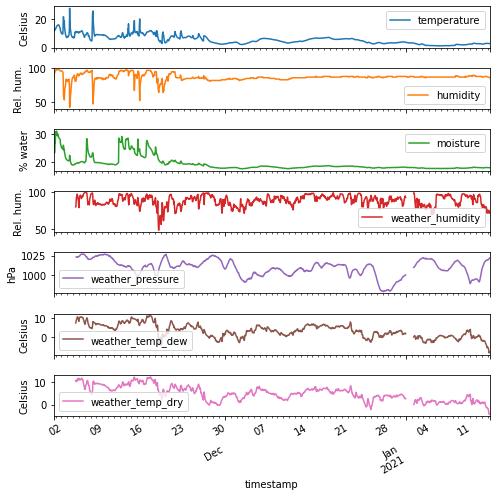

In [9]:
# Visualizing data
data.timestamp = pd.to_datetime(data.timestamp)
data = data.sort_values(['sensor_id','segment_id','timestamp'])
output_features = ['temperature','humidity','moisture','weather_humidity','weather_pressure','weather_temp_dew','weather_temp_dry']
axes = data.loc[(data.sensor_id ==54) & (data.segment_id == 160)].set_index('timestamp')[output_features].plot(subplots=True,figsize=(7,7),sharex=True)

ylabels = ['Celsius','Rel. hum.','% water','Rel. hum.','hPa','Celsius','Celsius']

for label,ax in zip(ylabels,axes.flatten()):
  ax.set_ylabel(label)

plt.tight_layout()
plt.show()

It can be seen that there is missing data points for the weather data. This will be handled by interpolations. 

### Find possible outliers for test set

Below is the moisture levels for sensors with length over one month inspected. It is of interest to set aside sensors containing potential outliers to evaluate on later on. 

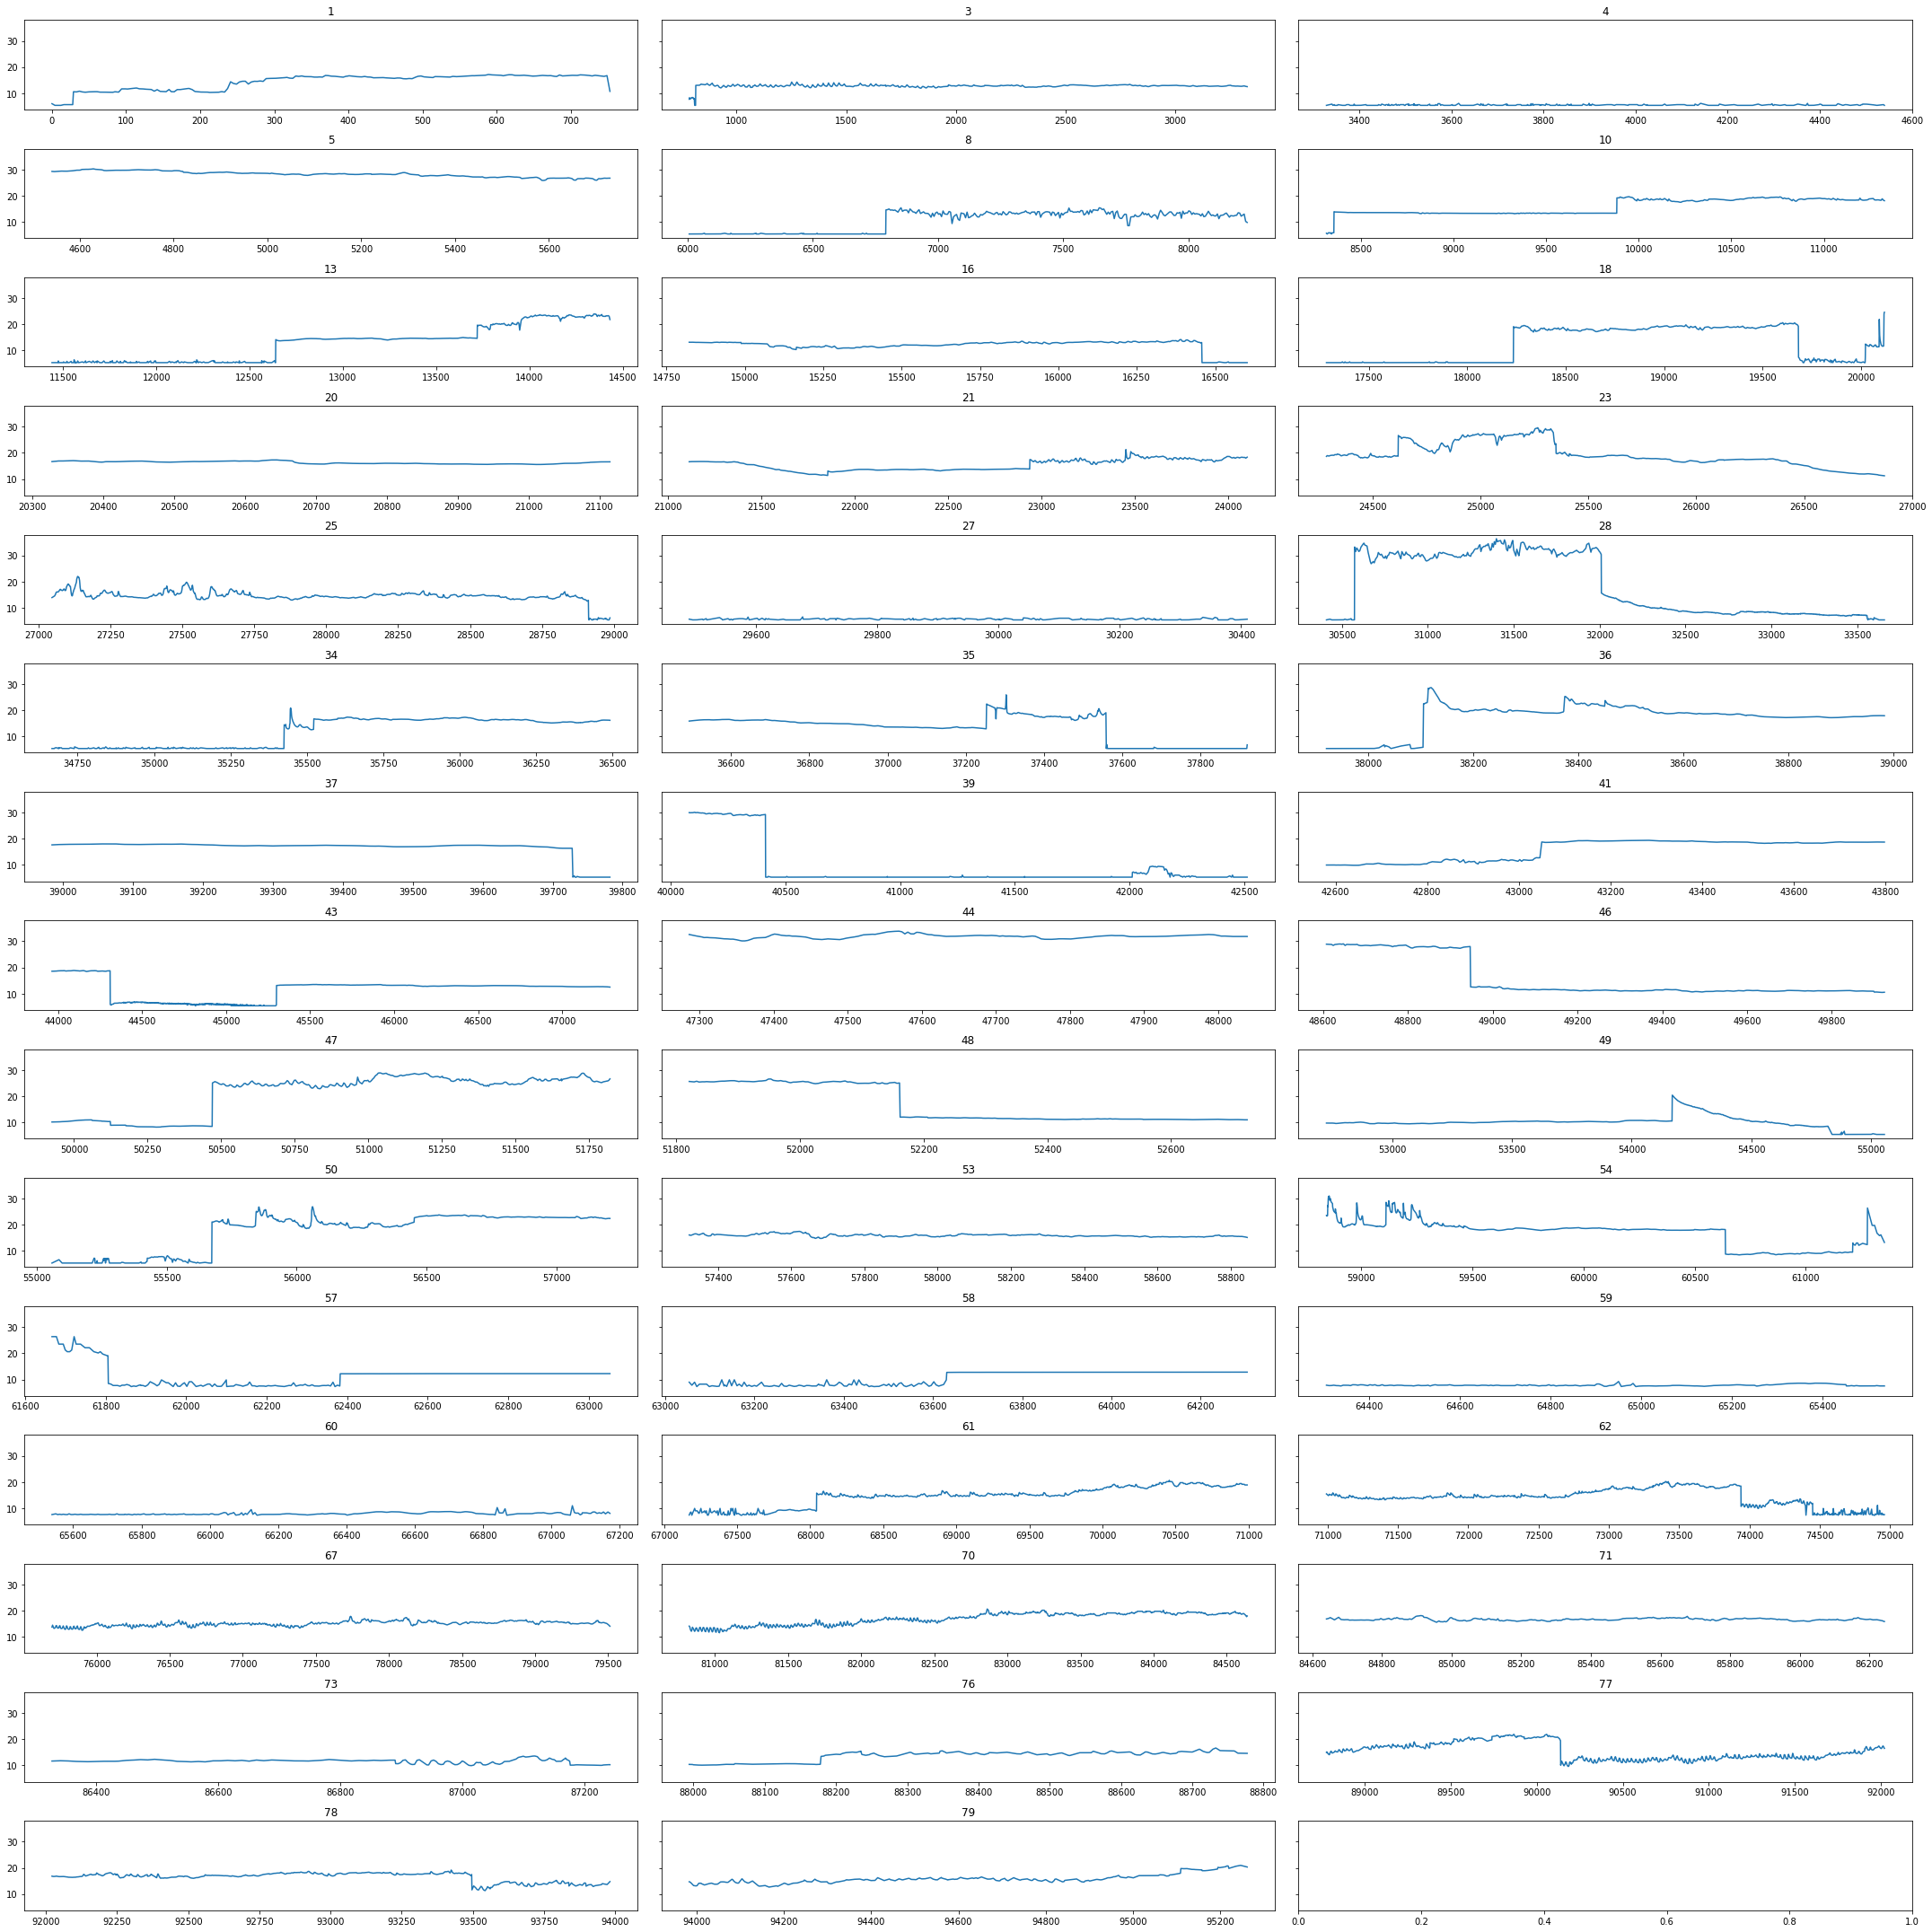

In [10]:
n_sensors_month = (data.groupby('sensor_id').size() > 720).sum()

n_cols = 3
n_rows = int(np.ceil(n_sensors_month/n_cols))

fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,sharey=True,figsize=(30,30))
axes = axes.flatten()

i = 0
for sensor, df in data[['sensor_id','timestamp','moisture']].groupby('sensor_id'):
  if len(df) > 720:
    df['moisture'].plot(ax=axes[i],title=sensor)
    i += 1

plt.tight_layout()

The candidates sensors are 13, 18, 28, 50 and 54. To make it possible for the VAE to handle possible anomaly sensors then some will be saved for training and validation. 

Sensor 50 and 54 are chosen for test set as well as random sensors 16 and 41. 

### Histogram of features

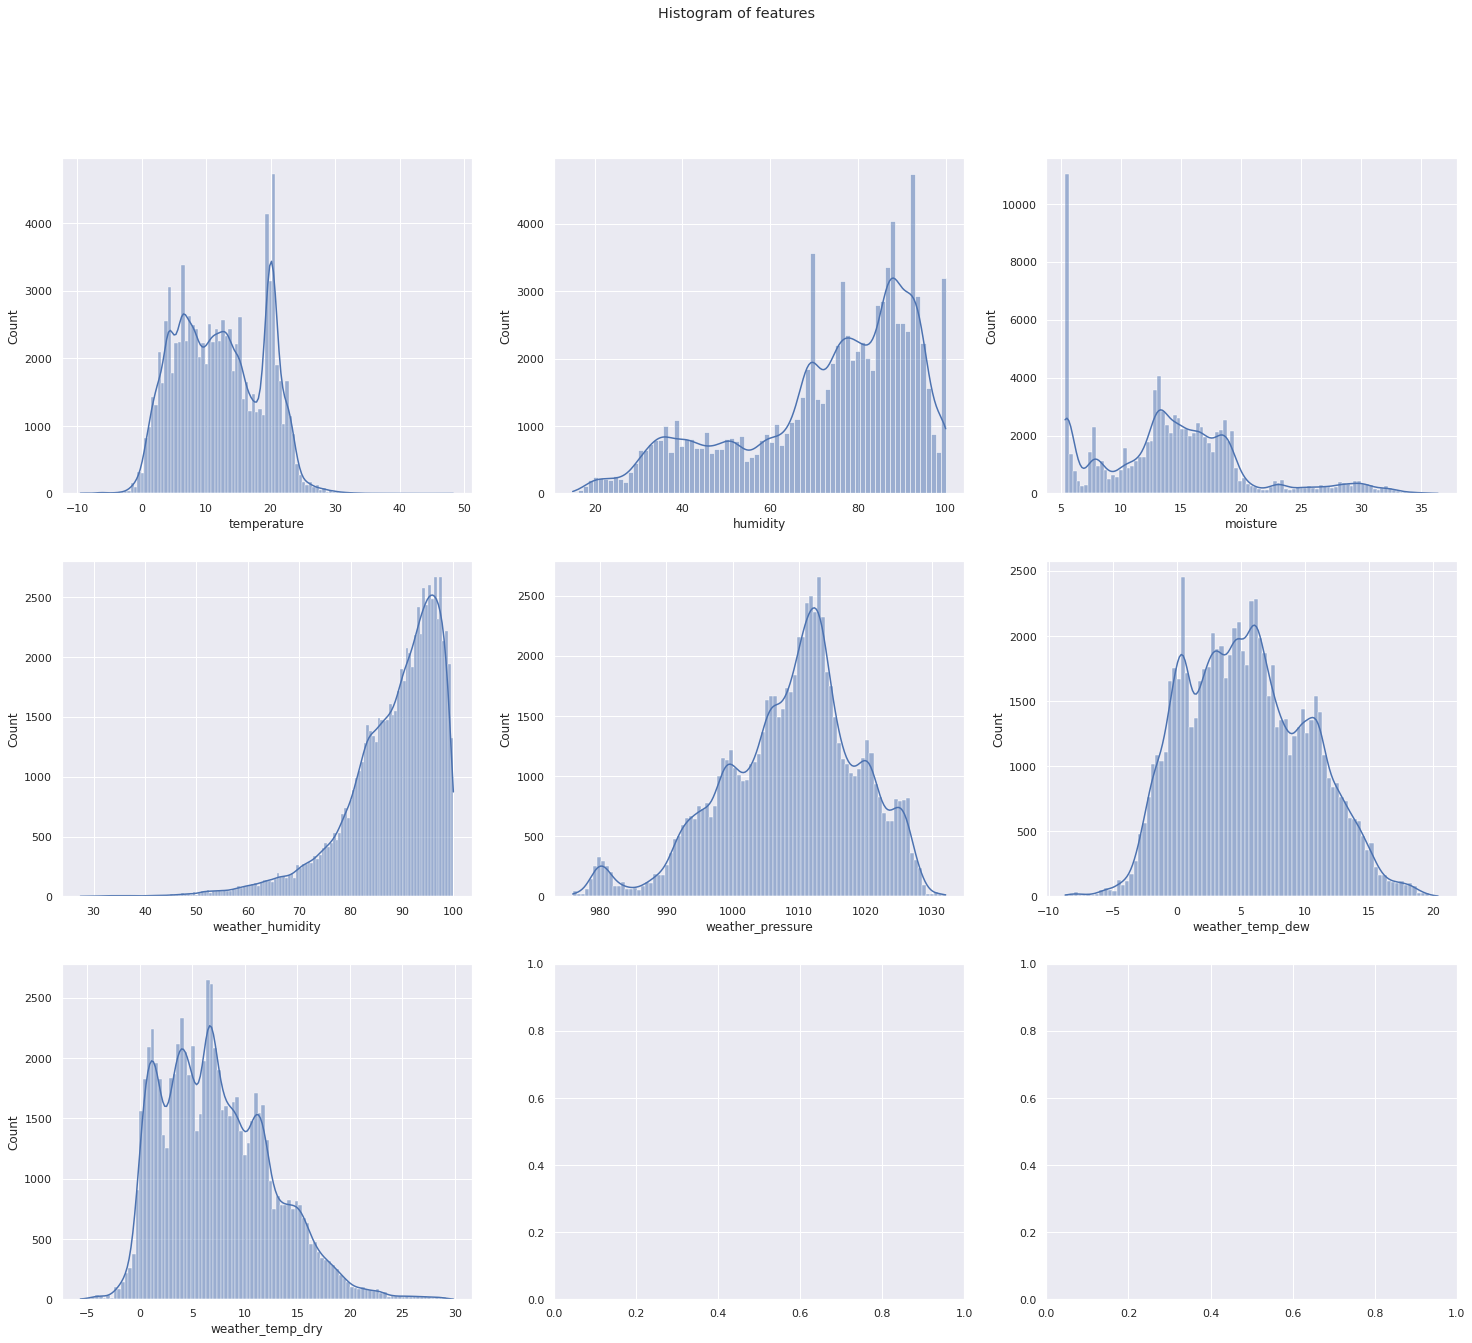

In [11]:
features_to_plot = ['temperature','humidity','moisture', 'weather_humidity',
                      'weather_pressure', 'weather_temp_dew', 'weather_temp_dry']

num_features = len(features_to_plot)
num_cols = 3
num_rows = int(np.ceil(num_features/num_cols))
sns.set_theme(color_codes=True)
fig, axes = plt.subplots(num_rows,num_cols, figsize=(25,7*num_rows))
axes = axes.flatten()
fig.suptitle('Histogram of features')

for i,f in enumerate(features_to_plot):
  sns.histplot(data=data,x=f,kde=True,ax=axes[i])



## Data processing

In [12]:
# Below preprocesses the data using the Preprocessor class.

## Loads data and removes any rows with NaN in sensor data
preprocess = Preprocessor(data,drop_sensor_nans=True,drop_weather_nans=False)
## For now weather features are dropped 
#preprocess.drop_weather_features()
#preprocess.drop_time_features()
preprocess.interpolate_weather_data()
#preprocess.remove_before_00()
preprocess.create_sensor_based_test_set(test_sensors = [16,50,54,60])

##  Make a sensorbased training and validation split
preprocess.sensor_based_train_val_split(val_size=0.2,random_seed = 20)
preprocess.standardise_train_val()
preprocess.standardise_test()

#Checking whether data shapes look correct
preprocess.train_data.shape, preprocess.val_data.shape, preprocess.test_data.shape

((55057, 14), (12645, 14), (7355, 14))

In [13]:
# Checking if data contain NaNs

preprocess.data.isna().sum()

segment_id          0
timestamp           0
temperature         0
humidity            0
moisture            0
weather_humidity    0
weather_pressure    0
weather_temp_dew    0
weather_temp_dry    0
sensor_id           0
tod_sin             0
tod_cos             0
doy_sin             0
doy_cos             0
dtype: int64

In [14]:
#Checking if the chosen features are the wanted features
preprocess.features

['temperature',
 'humidity',
 'moisture',
 'weather_humidity',
 'weather_pressure',
 'weather_temp_dew',
 'weather_temp_dry',
 'tod_sin',
 'tod_cos',
 'doy_sin',
 'doy_cos']

In [15]:
#Creating feature dict that is useful in visualizations
feature_dict = dict(zip(preprocess.features,range(len(preprocess.features))))

#Creating index for when conditional (time features) begin 
#Used when splitting data to x and c
t_idx = feature_dict['tod_sin']

In [16]:
#Calculating val size based on data
preprocess.val_data.shape[0]/(preprocess.train_data.shape[0]+preprocess.val_data.shape[0]+preprocess.test_data.shape[0])

0.16847196130940484

In [17]:
ws = 24
step = 1

w_train, time_train, sensor_train, features = window_maker(preprocess.train_data,window_size=ws,step_size=step)
w_val, time_val, sensor_val, features = window_maker(preprocess.val_data,window_size=ws,step_size=step)
w_val_viz, time_val_viz, sensor_val_viz, features = window_maker(preprocess.val_data,window_size=ws,step_size=ws)
w_test, time_test, sensor_test, features = window_maker(preprocess.test_data,window_size=ws,step_size=step)
w_test_viz, time_test_viz, sensor_test_viz, features = window_maker(preprocess.test_data,window_size=ws,step_size=ws)


train_data = DatasetVAE(w_train,time_train,sensor_train)
val_data = DatasetVAE(w_val,time_val,sensor_val)
val_data_viz = DatasetVAE(w_val_viz,time_val_viz,sensor_val_viz)
test_data = DatasetVAE(w_test, time_test, sensor_test)
test_data_viz =  DatasetVAE(w_test_viz, time_test_viz, sensor_test_viz)

#val_data[0]

In [18]:
bs = 128

train_loader = DataLoader(train_data,batch_size=bs,shuffle=True,num_workers=8)
val_loader = DataLoader(val_data,batch_size=bs,shuffle=False,num_workers=8)
val_loader_viz = DataLoader(val_data_viz,batch_size=bs,shuffle=False,num_workers=8) # Used for some latent visualizations
test_loader = DataLoader(test_data,batch_size=bs,shuffle=False,num_workers=8)
test_loader_viz = DataLoader(test_data_viz,batch_size=bs,shuffle=False,num_workers=8) # Usef for some latent visualizations

## Test if dataloader works correctly

Checking if batch size is correct

In [19]:
batch = next(iter(test_loader))

train_batch, time_batch, sensor_batch = batch

train_batch.shape,time_batch.shape, sensor_batch.shape

(torch.Size([128, 24, 11]), torch.Size([128, 24]), torch.Size([128, 2]))

#RNN VAE

In [20]:
class encoder(nn.Module):

  def __init__(self,input_features:int,latent_features:int,num_layers:int,dropout:float,bidirectional=False):
    super().__init__()

    self.input_features = input_features
    self.latent_features = latent_features
    self.num_layers = num_layers
    self.dropout = dropout
    self.bidirectional = bidirectional

    if bidirectional is True:
      self.num_directions = 2
    else:
      self.num_directions = 1

    #self.hidden_size1 = int((15*self.input_features)/self.num_directions)
    self.hidden_size1 = 80

    self.rnn1 = nn.GRU(
        input_size = self.input_features,
        hidden_size = self.hidden_size1,
        num_layers = self.num_layers,
        batch_first=True,
        dropout = self.dropout,
        bidirectional=self.bidirectional
    )


    self.linear_latent_input = self.num_directions*self.hidden_size1*ws
    self.linear_latent_output = 2*self.latent_features


    self.dropout_layer = nn.Dropout(p=self.dropout)
    self.linear_latent = nn.Linear(in_features = self.linear_latent_input,out_features=self.linear_latent_output)
    
  def forward(self, x):


    x,_ = self.rnn1(x)
    x = self.dropout_layer(x)
    
    #Concatenating all hidden_state outputs 
    #which will be be put through a linear layer
    x = x.reshape(x.size(0),1,-1)

    latent = self.linear_latent(x)

    return latent

In [21]:
bidirectional = True

x,t,s = next(iter(train_loader))
encoder_test = encoder(input_features=preprocess.num_features,latent_features=2,num_layers=5,dropout=0,bidirectional=bidirectional).to(device)
x = x.to(device)
mu, sigma = encoder_test(x).chunk(2,dim=-1)
mu.size(), sigma.size()

(torch.Size([128, 1, 2]), torch.Size([128, 1, 2]))

In [22]:
class decoder(nn.Module):

  def __init__(self,seq_len:int,latent_features:int,n_features_out:int,num_layers:int,dropout:float,bidirectional:bool):
    super().__init__()

    self.seq_len = seq_len
    self.latent_features = latent_features + 4 #4 conditional features i.e. tod and doy cs and sin features
    self.n_features_out = n_features_out
    self.num_layers = num_layers
    self.dropout = dropout
    self.bidirectional = bidirectional

    if bidirectional is True:
      self.num_directions = 2
    else:
      self.num_directions = 1

    #self.linear_layer_output = 15*self.n_features_out
    self.linear_layer_output = 80

    self.input_layer = nn.Linear(in_features=self.latent_features,out_features=self.linear_layer_output)

    #self.hidden_size1 = int(20*self.n_features_out/self.num_directions)
    self.hidden_size1 = 80

    self.rnn1 = nn.GRU(
        input_size = self.linear_layer_output,
        hidden_size = self.hidden_size1,
        num_layers=self.num_layers,
        batch_first = True,
        dropout = self.dropout,
        bidirectional=self.bidirectional
    )


    self.output_layer = nn.Linear(in_features=self.hidden_size1*self.num_directions,out_features=self.n_features_out,bias=True)
    self.dropout_layer = nn.Dropout(p=self.dropout)

  def forward(self,z,c):
    z = z.repeat(1,self.seq_len,1)
    z = torch.cat((z,c),2)
    
    x = self.input_layer(z)
    x,_ = self.rnn1(x)
    x = self.dropout_layer(x)
    
    x = self.output_layer(x)

    return x

In [23]:
dist = Normal(mu,sigma)
decoder_test = decoder(seq_len=24,latent_features=2,n_features_out=preprocess.num_features-4,num_layers=2,dropout=0,bidirectional=bidirectional).to(device)

decoder_test(dist.rsample().to(device),torch.ones(bs,ws,4).to(device)).size()

torch.Size([128, 24, 7])

In [24]:
class RNNVAE(nn.Module):
    
    def __init__(self, input_features:int, latent_features:int,observation_features:int,ws:int,num_layers:int,dropout:int,bidirectional:bool) -> None:
        super().__init__()
        
        self.input_features = input_features
        self.latent_features = latent_features
        self.observation_features = observation_features
        self.ws = ws
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.dropout = dropout

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = encoder(input_features=self.input_features,
                               latent_features=self.latent_features,
                               num_layers=self.num_layers,
                               dropout=self.dropout,
                               bidirectional=self.bidirectional
                               )        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = N(mu(z),sigma(z))
        self.decoder = decoder(seq_len=self.ws,
                               latent_features=self.latent_features,
                               n_features_out=self.observation_features,
                               num_layers=self.num_layers,
                               dropout=self.dropout,
                               bidirectional=self.bidirectional
                               )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor):
        """return the distribution `q(z|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        sigma = log_sigma.exp()
        return Normal(mu, sigma)
    
    def prior(self, batch_size:int=1):
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size,*self.prior_params.shape)
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        sigma = log_sigma.exp()
        return Normal(mu, sigma)

    def observation_model(self,z:Tensor,c:Tensor):
      """returns p(x|z)"""
      px_logits = self.decoder(z,c) 

      return px_logits
        

    def forward(self, x,c):
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))

        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) 
        px = self.observation_model(z,c)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}


# Inference model

In [25]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).mean(dim=1) # sum before that

class ConditionalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor,c:Tensor,k:int=1):

        w_i = []
        beta_K = []

        for i in range(k):
          # forward pass through the model
          outputs = model(x,c)
          
          # unpack outputs
          x_hat, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]

          x_orig = x[:,:,:t_idx].to(device) # q(z|x,c) enabling
          
          # evaluate log probabilities
          #log_px = reduce(px.log_prob(x)) # p(x|z)- observation model: Normal distribution without reparimisation trick (unnecessary) <-- own comments 
          log_px = reduce((x_orig-x_hat)**2) # Euclidian distance as measure for log-likelihood for p(x|z)
          log_pz = reduce(pz.log_prob(z)) # p(z) - prior:  Normal dist with mean 0 and std = 1 <-- own comments
          log_qz = reduce(qz.log_prob(z)) # q(z|x) - posterior: Normal, thus N(z|u(x),epsilon)(x)) <-- own comments

        
          # compute the ELBO with and without the beta parameter: 
          # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
          # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
          kl = log_qz - log_pz # Original from deep learning exercise
          elbo = -log_px - kl # <- your code here
          beta_elbo =  -log_px - self.beta*kl # <- your code here

          w_i += [beta_elbo.view(beta_elbo.size(0),1).exp()] # List of beta probabilities
          beta_K += [beta_elbo.view(beta_elbo.size(0),1)] # list containing beta elbo scores

        self.w_i = torch.cat(w_i,dim=1)
        self.w_tilde = self.w_i/self.w_i.sum(1).view(self.w_i.size(0),1) # Calculating importance weights. Note the softmax could also be taken of each beta_elbo loss to compute weight importance
        self.beta_K = torch.cat(beta_K,dim=1)

        self.importance_weighted_loss = (self.w_tilde*self.beta_K).sum(1) # Returning importance weight beta-elbo loss
        
        # loss
        #loss = -beta_elbo.mean() # uncomment for normal beta-elbo loss
        loss = -self.importance_weighted_loss.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [26]:
# Testing RNN VAE
latent_features = 2
rnnvae = RNNVAE(input_features=preprocess.num_features-4,latent_features=latent_features,observation_features=preprocess.num_features-4,
                ws=ws,num_layers=1,dropout=0,bidirectional=True)
x,t,s = next(iter(train_loader))

c = x[:,:,t_idx:].to(device)
x = x[:,:,:t_idx].to(device) # q(z|x) - Conditions only in latent space
#x = x.to(device) # q(z|x,c) enabling
#print(x.size(),c.size())


rnnvae.to(device)
vi_rnn = ConditionalInference(beta=1.0)
vi_rnn.to(device)
loss, diagnostics, outputs = vi_rnn(rnnvae, x,c,k=1)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")



loss   | mean =      1.088, shape: []
elbo   | mean =     -1.088, shape: [128]
log_px | mean =      1.056, shape: [128]
kl     | mean =      0.032, shape: [128]


# Model training

## Initialize RNN model

In [27]:
# RNN VAE
latent_features = 32
#input_features = preprocess.num_features -4 # q(z|x)
input_features = preprocess.num_features # q(z|x,c)
observation_features = preprocess.num_features -4
num_layers = 1 # num_layers in decoder
dropout = 0 # dropout in linear layers
bidirectional = True # if GRU is bidirectional

rnnvae = RNNVAE(input_features=input_features,latent_features=latent_features,observation_features=observation_features,
                ws=ws,num_layers=num_layers,dropout=dropout,bidirectional=bidirectional).to(device)

# Evaluator: Variational Inference
beta = 0.015
vi_rnn = ConditionalInference(beta=beta).to(device)

# The Adam optimizer works really well with VAEs.
optimizer_rnn = torch.optim.Adam(rnnvae.parameters(), lr=1e-3)

#Initialiating learning rate plateau scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_rnn,mode='min',factor=0.1,patience=10,threshold=0.0001,min_lr=1e-5)


## Training RNN VAE

Epoch number: 100
Current best loss 0.021297672763466835, best MSE 0.009477780753193976 and best KL Div. 0.7873219297482417
Current beta is: 0.015
Current learning rate 0.001


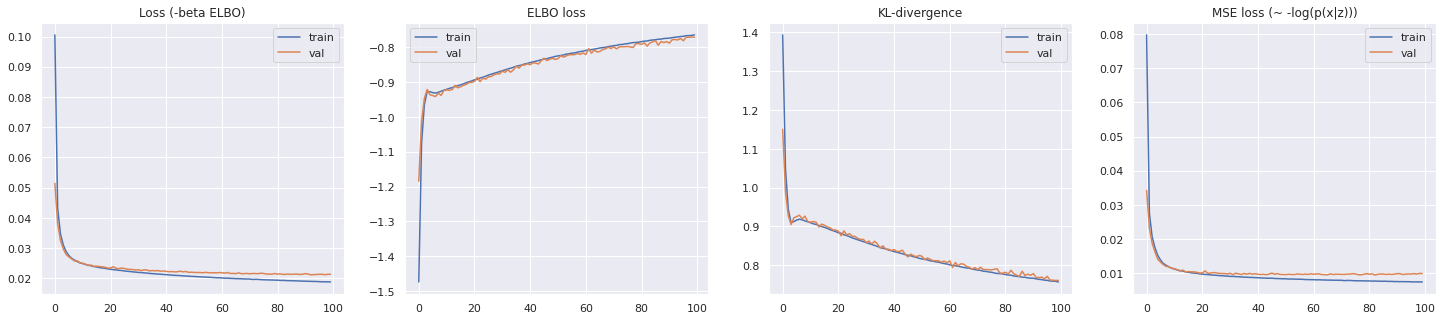

RNNVAE(
  (encoder): encoder(
    (rnn1): GRU(11, 80, batch_first=True, bidirectional=True)
    (dropout_layer): Dropout(p=0, inplace=False)
    (linear_latent): Linear(in_features=3840, out_features=64, bias=True)
  )
  (decoder): decoder(
    (input_layer): Linear(in_features=36, out_features=80, bias=True)
    (rnn1): GRU(80, 80, batch_first=True, bidirectional=True)
    (output_layer): Linear(in_features=160, out_features=7, bias=True)
    (dropout_layer): Dropout(p=0, inplace=False)
  )
)

In [32]:
from IPython.display import clear_output
import copy
sns.set_theme(color_codes=True)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0
num_epochs = 100
print(f">> Using device: {device}")
best_mse = 100000
best_loss = 100000

k_iterations = 10

while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    validation_epoch_data = defaultdict(list)
    rnnvae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    loss_epoch_train = []
    for x, t, s in train_loader:

        
        c = x[:,:,t_idx:].to(device)
        #x = x[:,:,:t_idx].to(device) # q(z|x)
        x = x.to(device) # q(z|x,c)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi_rnn(rnnvae, x,c,k_iterations)
        
        optimizer_rnn.zero_grad()
        loss.backward()
        optimizer_rnn.step()
        
        # gather data for the current batch
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

        loss_epoch_train += [loss.detach().cpu().numpy()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    loss_save = np.array(loss_epoch_train).mean()
    training_data['loss(-beta_elbo)'] += [loss_save]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        rnnvae.eval()
        loss_epoch_val = []
        for x,t,s in val_loader:
        
          c = x[:,:,t_idx:].to(device)
          #x = x[:,:,:t_idx].to(device) # q(z|x)
          x = x.to(device) # q(z|x,c)
          
          # perform a forward pass through the model and compute the ELBO
          val_loss, diagnostics, outputs = vi_rnn(rnnvae, x,c,k_iterations)
          
          # gather data for the validation step
          for k, v in diagnostics.items():
              validation_epoch_data[k] += [v.mean().item()]

          loss_epoch_val += [val_loss.detach().cpu().numpy()]

    scheduler.step(val_loss)

          
    for k, v in validation_epoch_data.items():
      validation_data[k] += [np.mean(validation_epoch_data[k])]
    
    loss_save = np.array(loss_epoch_val).mean()
    validation_data['loss(-beta_elbo)'] += [loss_save]

    if validation_data['log_px'][-1] < best_mse:
      best_mse = validation_data['log_px'][-1]
      best_loss = validation_data['loss(-beta_elbo)'][-1]
      best_kl = validation_data['kl'][-1]
      best_model = copy.deepcopy(rnnvae.state_dict())

    ## Plotting progress

    clear_output(wait=True)
    print(f'Epoch number: {epoch}')
    print(f'Current best loss {best_loss}, best MSE {best_mse} and best KL Div. {best_kl}')
    print(f'Current beta is:',vi_rnn.beta)
    lr = optimizer_rnn.param_groups[-1]['lr']
    print(f'Current learning rate {lr}')
    fig, axes = plt.subplots(1,4, figsize=(25,5))

    titles = ['Loss (-beta ELBO)','ELBO loss','KL-divergence','MSE loss (~ -log(p(x|z)))']

    for i,k in enumerate(['loss(-beta_elbo)','elbo','kl','log_px']):
      train = training_data[k]
      val = validation_data[k]

      axes[i].plot(train,label=f'train')
      axes[i].plot(val,label='val')
      axes[i].set_title(titles[i])
      axes[i].legend()

    plt.show()  

# Load best model during training measured on mse loss
rnnvae.load_state_dict(best_model)
rnnvae.eval()

# Saving and/or Loading Model

## Saving

In [33]:
# Uncomment if you wish to save a model and give it a name in model_name
# path = '/content/drive/MyDrive/WoodSense Generative Models/models/' 
# model_name = 'RNNIWAE_input_w_c_32_1_layer_0_p_k_10_step_1_beta_0.015'
# torch.save(rnnvae.state_dict(), path+model_name)  

## Loading

In [28]:
path = '/content/drive/MyDrive/WoodSense Generative Models/models/' 
model_name = 'RNNIWAE_input_w_c_32_1_layer_0_p_k_10_step_1_beta_0.015'
rnnvae.load_state_dict(torch.load(path+model_name))
rnnvae.eval()

RNNVAE(
  (encoder): encoder(
    (rnn1): GRU(11, 80, batch_first=True, bidirectional=True)
    (dropout_layer): Dropout(p=0, inplace=False)
    (linear_latent): Linear(in_features=3840, out_features=64, bias=True)
  )
  (decoder): decoder(
    (input_layer): Linear(in_features=36, out_features=80, bias=True)
    (rnn1): GRU(80, 80, batch_first=True, bidirectional=True)
    (output_layer): Linear(in_features=160, out_features=7, bias=True)
    (dropout_layer): Dropout(p=0, inplace=False)
  )
)

# Visualizations

In [29]:
def time_feature_converter(t):
    t = t[:,:ws]
    t = t.reshape(t.size(0)*t.size(1)).cpu().numpy()
    time_df = pd.DataFrame({'timestamp':t})
    time_df['timestamp'] = pd.to_datetime(time_df['timestamp'])
    time_df['tod'] = time_df['timestamp'].dt.hour
    time_df['doy'] = time_df['timestamp'].dt.dayofyear

    toy = time_df['tod'].to_numpy()
    doy = time_df['doy'].to_numpy()[::ws]

    return toy, doy


In [30]:
def plot_2d_latents(ax, qz, z, t,ellipse=False):
    z = z.to('cpu')
    scale_factor = 2
    batch_size = z.shape[0]
    cm = plt.cm.get_cmap('summer')

    # plot prior
    prior = plt.Circle((0, 0), scale_factor, color='gray', fill=True, alpha=0.1)
    ax.add_artist(prior)

    # plot data points
    if ellipse is True:
      mus, sigmas = qz.mu.to('cpu'), qz.sigma.to('cpu')
      mus = [mus[i].numpy().tolist() for i in range(batch_size)]
      sigmas = [sigmas[i].numpy().tolist() for i in range(batch_size)]

      posteriors = [
          plt.matplotlib.patches.Ellipse(mus[i], *(scale_factor * s for s in sigmas[i]),color='red', fill=False,
                                        alpha=0.3) for i in range(batch_size)]
      for p in posteriors:
          ax.add_artist(p)

    #ax.scatter(z[:, 0], z[:, 1], color=colors)
    sc = ax.scatter(z[:,0],z[:,1],c=t,vmin=t.min(),vmax=t.max(),s=35,cmap=cm,alpha=0.4)

    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_aspect('equal', 'box')

    return sc

In [31]:
def plot_latents(ax, z, t):

  if torch.is_tensor(z):
    z = z.to('cpu')

  cm = plt.cm.get_cmap('summer')
  z = TSNE(n_components=2).fit_transform(z)

  #ax.set_xlim(-55,55)
  #ax.set_ylim(-55,55)

  sc = ax.scatter(z[:,0],z[:,1],c=t,vmin=t.min(),vmax=t.max(),s=35,cmap=cm)
  return sc

## Latent  samples colored after features

### Validation samples

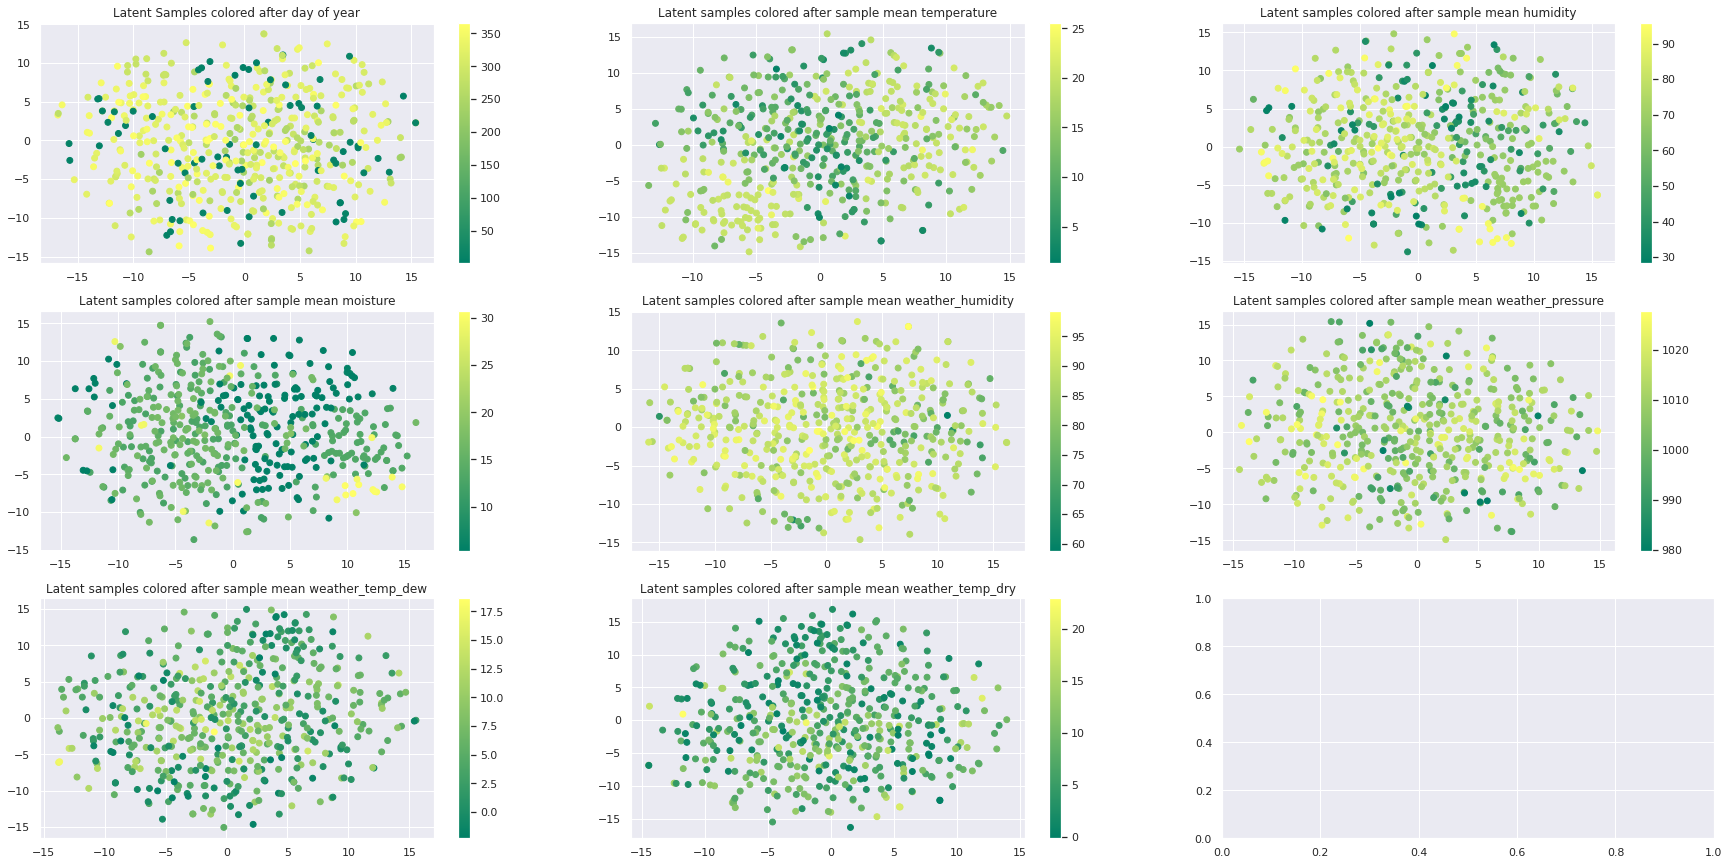

In [32]:
with torch.no_grad():
  rnnvae.eval()

  num_cols = 3
  num_rows = int(np.ceil((preprocess.num_features-4)/num_cols))

  fig, axes = plt.subplots(num_rows,num_cols, figsize=(30,15))
  axes = axes.flatten()

  i = 0
  for x,t,s in val_loader_viz:

    if i == 0:
      c = x[:,:,t_idx:].to(device)
      #x_all = x[:,:,:t_idx].to(device)
      x_all = x.to(device)

      tod_all, doy_all = time_feature_converter(t)

      loss, diagnostics, outputs = vi_rnn(rnnvae, x_all,c)
      z_all = outputs['z']
    else:

      c = x[:,:,t_idx:].to(device)
      #x = x[:,:,:t_idx].to(device) # q(z|x)
      x = x.to(device) # q(z|x,c)
      x_all = torch.cat((x_all,x),0)

      tod, doy = time_feature_converter(t)
      doy_all = np.concatenate((doy_all,doy),0)

      loss, diagnostics, outputs = vi_rnn(rnnvae, x,c)
      z = outputs['z']
      z_all = torch.cat((z_all,z),0)

    i += 1


  x_all = preprocess.standardiser.inverse_transform(x_all[:,:,:t_idx].cpu().numpy())
  means_per_sample_all = x_all.mean(1)


  z_all = z_all[:,-1,:]
  if z_all.shape[1] == 2:
    ellipses = False
    qz = outputs['qz'] # qz only used if ellipses = True
    axes[0].set_title(r'Latent Samples colored after day of year')
    sc = plot_2d_latents(axes[0],qz,z_all,doy_all,ellipse=ellipses)
    fig.colorbar(sc,ax=axes[0])

    for i, f in enumerate(preprocess.features[:t_idx]):
      axes[i+1].set_title(f'Latent samples colored after sample mean {f}')
      sc = plot_2d_latents(axes[i+1],qz,z_all,means_per_sample_all[:,i],ellipse=ellipses)
      fig.colorbar(sc,ax=axes[i+1])

    
  else: 
    axes[0].set_title(r'Latent Samples colored after day of year')
    sc = plot_latents(axes[0],z_all,doy_all)
    fig.colorbar(sc,ax=axes[0])

    for i, f in enumerate(preprocess.features[:t_idx]):
      axes[i+1].set_title(f'Latent samples colored after sample mean {f}')
      sc = plot_latents(axes[i+1],z_all,means_per_sample_all[:,i])
      fig.colorbar(sc,ax=axes[i+1])
    

### Test samples

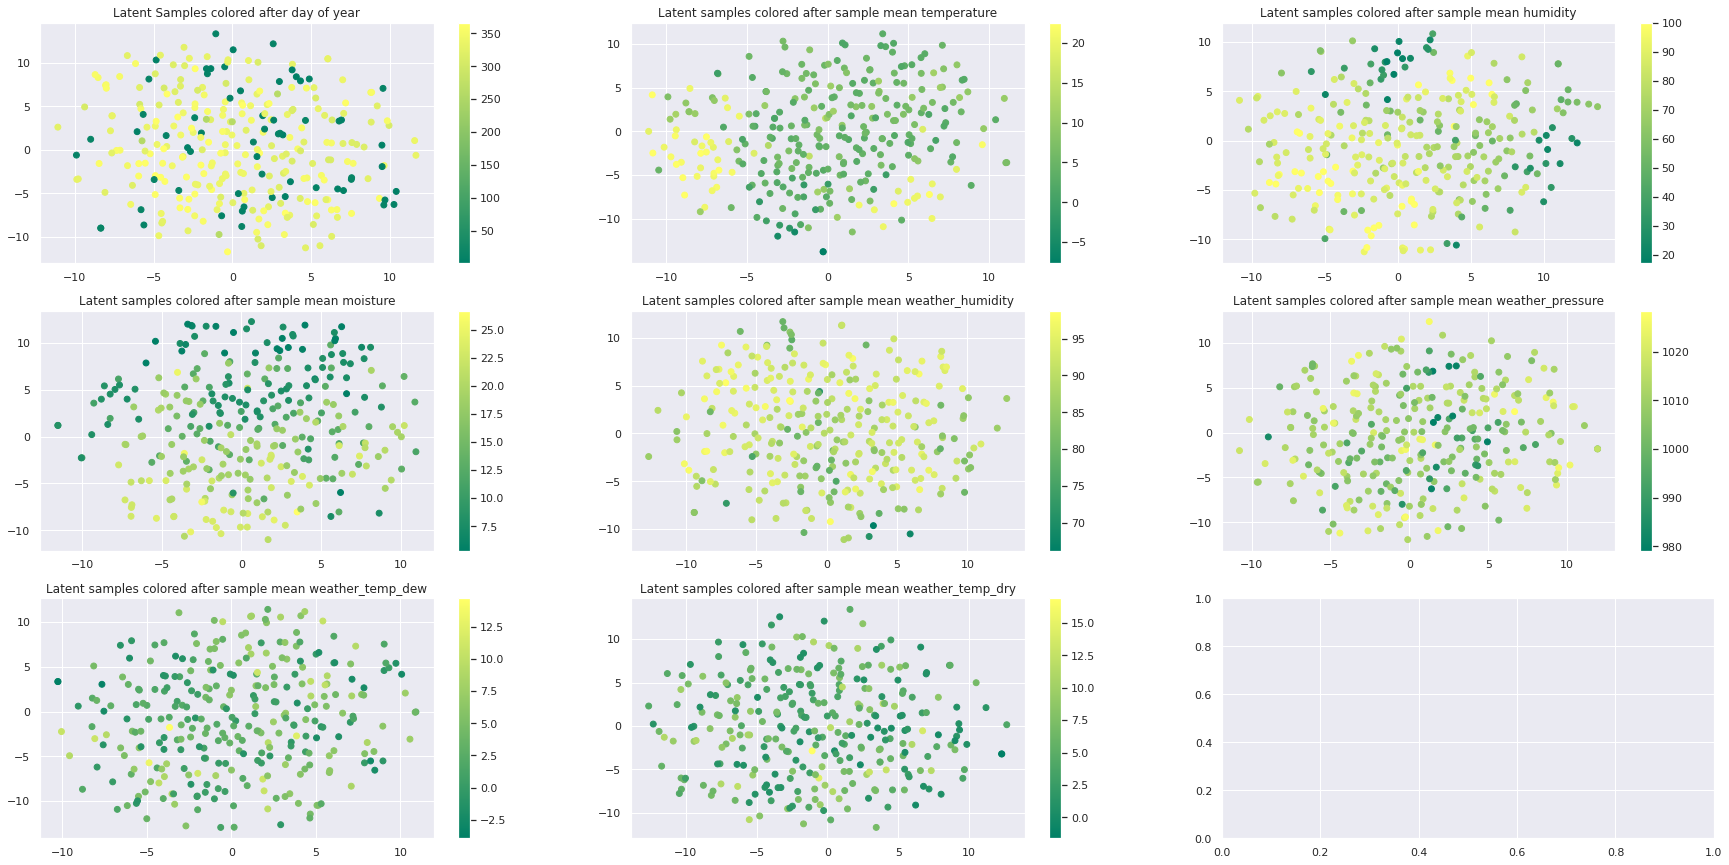

In [33]:
with torch.no_grad():
  rnnvae.eval()

  num_cols = 3
  num_rows = int(np.ceil((preprocess.num_features-4)/num_cols))

  fig, axes = plt.subplots(num_rows,num_cols, figsize=(30,15))
  axes = axes.flatten()

  i = 0
  for x,t,s in test_loader_viz:

    if i == 0:
      c = x[:,:,t_idx:].to(device)
      #x_all = x[:,:,:t_idx].to(device) # q(z|x)
      x_all = x.to(device) # q(z|x,c)

      tod_all, doy_all = time_feature_converter(t)

      loss, diagnostics, outputs = vi_rnn(rnnvae, x_all,c)
      z_all = outputs['z']
    else:

      c = x[:,:,t_idx:].to(device)
      #x = x[:,:,:t_idx].to(device) # q(z|x,c)
      x = x.to(device) # q(z|x,c)
      x_all = torch.cat((x_all,x),0)

      tod, doy = time_feature_converter(t)
      doy_all = np.concatenate((doy_all,doy),0)

      loss, diagnostics, outputs = vi_rnn(rnnvae, x,c)
      z = outputs['z']
      z_all = torch.cat((z_all,z),0)


    i += 1


  x_all = preprocess.standardiser.inverse_transform(x_all[:,:,:t_idx].cpu().numpy())
  means_per_sample_all = x_all.mean(1)

  z_all = z_all[:,-1,:]
  if z_all.shape[1] == 2:
    ellipses = False
    qz = outputs['qz'] # qz only used if ellipses = True
    axes[0].set_title(r'Latent Samples colored after day of year')
    sc = plot_2d_latents(axes[0],qz,z_all,doy_all,ellipse=ellipses)
    fig.colorbar(sc,ax=axes[0])

    for i, f in enumerate(preprocess.features[:t_idx]):
      axes[i+1].set_title(f'Latent samples colored after sample mean {f}')
      sc = plot_2d_latents(axes[i+1],qz,z_all,means_per_sample_all[:,i],ellipse=ellipses)
      fig.colorbar(sc,ax=axes[i+1])

    
  else: 
    axes[0].set_title(r'Latent Samples colored after day of year')
    sc = plot_latents(axes[0],z_all,doy_all)
    fig.colorbar(sc,ax=axes[0])

    for i, f in enumerate(preprocess.features[:t_idx]):
      axes[i+1].set_title(f'Latent samples colored after sample mean {f}')
      sc = plot_latents(axes[i+1],z_all,means_per_sample_all[:,i])
      fig.colorbar(sc,ax=axes[i+1])
    

## Dataframes holding original and reconstruction information calculated for a single iteration of each data and a mean 

###Validation mean and std rnn_df

In [34]:
with torch.no_grad():
    rnnvae.eval()
    rnn_df_val = pd.DataFrame({
          'sensor_id':[],
          'segment_id':[],
          'timestamp':[],
          'latent_space':[],
          'mse':[]
      })
    for f in preprocess.features[:t_idx]:
      rnn_df_val[f] =[]
      rnn_df_val[f+'_hat'] = []

    for x,t,s in val_loader:

      c = x[:,:,t_idx:].to(device)
      #x = x[:,:,:t_idx].to(device) # q(z|x)
      x = x.to(device) # q(z|x,c)
      t = t[:,:ws]
      
      # perform a forward pass through the model and compute the ELBO
      loss, diagnostics, outputs = vi_rnn(rnnvae, x,c)

      x = x.view(-1,x.size(2)).cpu().numpy()
      x_hat = outputs['px']
      z = outputs['z'].cpu().numpy()[:,-1,:]
      z =np.repeat(z,ws,axis=0).tolist()
      x_hat = x_hat.view(-1,x_hat.size(2)).cpu().numpy()
      t = t.reshape(ws*t.size(0)).cpu().numpy()
      sensor = s[:,0]
      segment = s[:,1]
      sensor = torch.transpose(sensor.repeat(ws,1),0,1).reshape(ws*sensor.size(0)).cpu().numpy()
      segment = torch.transpose(segment.repeat(ws,1),0,1).reshape(ws*segment.size(0)).cpu().numpy()

      mse = ((x[:,:t_idx]-x_hat)**2).mean(1)
      
      tmp = pd.DataFrame({
          'sensor_id':sensor,
          'segment_id':segment,
          'timestamp':t,
          'latent_space':z,
          'mse':mse,
      })

      x = preprocess.standardiser.inverse_transform(x[:,:t_idx])
      x_hat = preprocess.standardiser.inverse_transform(x_hat)


      for i,f in enumerate(preprocess.features[:t_idx]):
        tmp[f] = x[:,i]
        tmp[f+'_hat'] = x_hat[:,i]

      rnn_df_val = rnn_df_val.append(tmp)
      rnn_df_val = rnn_df_val.reset_index(drop=True)

rnn_df_val = rnn_df_val.reset_index(drop=True)
rnn_df_val.timestamp = pd.to_datetime(rnn_df_val.timestamp)
rnn_df_val = rnn_df_val.sort_values(by=['sensor_id','timestamp']).reset_index(drop=True)

drop_hats = [f+'_hat' for f in preprocess.features[:t_idx]] + ['mse']

rnn_df_stat = rnn_df_val.drop(columns=drop_hats).groupby(['sensor_id','segment_id','timestamp']).mean().dropna()

rnn_df_stat = rnn_df_stat.reset_index(level=[0,1,2])

cols_to_drop =  preprocess.features[:t_idx]

rnn_df_size = rnn_df_val.drop(columns=cols_to_drop).groupby(['sensor_id','segment_id','timestamp']).size().dropna()
rnn_df_size = rnn_df_size.reset_index(level=[0,1,2]).rename(columns={0:'n_predictions'})

rnn_df_mean = rnn_df_val.drop(columns=cols_to_drop).groupby(['sensor_id','segment_id','timestamp']).mean().dropna()
mean_dict = dict([(f,f+'_mean') for f in rnn_df_mean])
rnn_df_mean = rnn_df_mean.rename(columns=mean_dict).reset_index(level=[0,1,2])

rnn_df_std = rnn_df_val.drop(columns=cols_to_drop).groupby(['sensor_id','segment_id','timestamp']).std().dropna()
std_dict = dict([(f,f+'_std') for f in rnn_df_std])
rnn_df_std = rnn_df_std.rename(columns=std_dict).reset_index(level=[0,1,2])

for df in [rnn_df_mean,rnn_df_std,rnn_df_size]:
  rnn_df_stat = rnn_df_stat.merge(df,how='inner',on=['sensor_id','segment_id','timestamp'])

rnn_df_val_stat = rnn_df_stat.copy()

Computing outlier threshold based on the 95% quantile of the mean euclidian distance. The euclidian distance is a mean because that each data sample can show up a maximum of 24 times. 

In [35]:
out_thres = rnn_df_val_stat['mse_mean'].quantile(0.99)
out_thres

0.04139850266277781

### Test mean and std rnn df

In [36]:
with torch.no_grad():
    rnnvae.eval()
    rnn_df_test = pd.DataFrame({
          'sensor_id':[],
          'segment_id':[],
          'timestamp':[],
          'latent_space':[],
          'mse':[]
      })
    for f in preprocess.features[:t_idx]:
      rnn_df_test[f] =[]
      rnn_df_test[f+'_hat'] = []

    for x,t,s in test_loader:

      c = x[:,:,t_idx:].to(device)
      #x = x[:,:,:t_idx].to(device) # q(z|x)
      x = x.to(device) # q(z|x,c)
      t = t[:,:ws]
      
      # perform a forward pass through the model and compute the ELBO
      loss, diagnostics, outputs = vi_rnn(rnnvae, x,c)

      x = x.view(-1,x.size(2)).cpu().numpy()
      x_hat = outputs['px']
      z = outputs['z'].cpu().numpy()[:,-1,:]
      z =np.repeat(z,ws,axis=0).tolist()
      x_hat = x_hat.view(-1,x_hat.size(2)).cpu().numpy()
      t = t.reshape(ws*t.size(0)).cpu().numpy()
      sensor = s[:,0]
      segment = s[:,1]
      sensor = torch.transpose(sensor.repeat(ws,1),0,1).reshape(ws*sensor.size(0)).cpu().numpy()
      segment = torch.transpose(segment.repeat(ws,1),0,1).reshape(ws*segment.size(0)).cpu().numpy()

      mse = ((x[:,:t_idx]-x_hat)**2).mean(1)
      
      tmp = pd.DataFrame({
          'sensor_id':sensor,
          'segment_id':segment,
          'timestamp':t,
          'latent_space':z,
          'mse':mse,
      })

      x = preprocess.standardiser.inverse_transform(x[:,:t_idx])
      x_hat = preprocess.standardiser.inverse_transform(x_hat)


      for i,f in enumerate(preprocess.features[:t_idx]):
        tmp[f] = x[:,i]
        tmp[f+'_hat'] = x_hat[:,i]

      rnn_df_test = rnn_df_test.append(tmp)
      rnn_df_test = rnn_df_test.reset_index(drop=True)

rnn_df_test = rnn_df_test.reset_index(drop=True)
rnn_df_test.timestamp = pd.to_datetime(rnn_df_test.timestamp)
rnn_df_test = rnn_df_test.sort_values(by=['sensor_id','timestamp']).reset_index(drop=True)

drop_hats = [f+'_hat' for f in preprocess.features[:t_idx]] + ['mse']

rnn_df_stat = rnn_df_test.drop(columns=drop_hats).groupby(['sensor_id','segment_id','timestamp']).mean().dropna()

rnn_df_stat = rnn_df_stat.reset_index(level=[0,1,2])

cols_to_drop =  preprocess.features[:t_idx]

rnn_df_size = rnn_df_test.drop(columns=cols_to_drop).groupby(['sensor_id','segment_id','timestamp']).size().dropna()
rnn_df_size = rnn_df_size.reset_index(level=[0,1,2]).rename(columns={0:'n_predictions'})

rnn_df_mean = rnn_df_test.drop(columns=cols_to_drop).groupby(['sensor_id','segment_id','timestamp']).mean().dropna()
mean_dict = dict([(f,f+'_mean') for f in rnn_df_mean])
rnn_df_mean = rnn_df_mean.rename(columns=mean_dict).reset_index(level=[0,1,2])

rnn_df_std = rnn_df_test.drop(columns=cols_to_drop).groupby(['sensor_id','segment_id','timestamp']).std().dropna()
std_dict = dict([(f,f+'_std') for f in rnn_df_std])
rnn_df_std = rnn_df_std.rename(columns=std_dict).reset_index(level=[0,1,2])

for df in [rnn_df_mean,rnn_df_std,rnn_df_size]:
  rnn_df_stat = rnn_df_stat.merge(df,how='inner',on=['sensor_id','segment_id','timestamp'])

rnn_df_test_stat = rnn_df_stat.copy()

Assigning each point to be an outlier or not based on the 95% quantile threshold given from the validation set

In [37]:
rnn_df_test_stat['Outlier'] = rnn_df_test_stat.mse_mean > out_thres

## Plotting regression error

### Validation sample

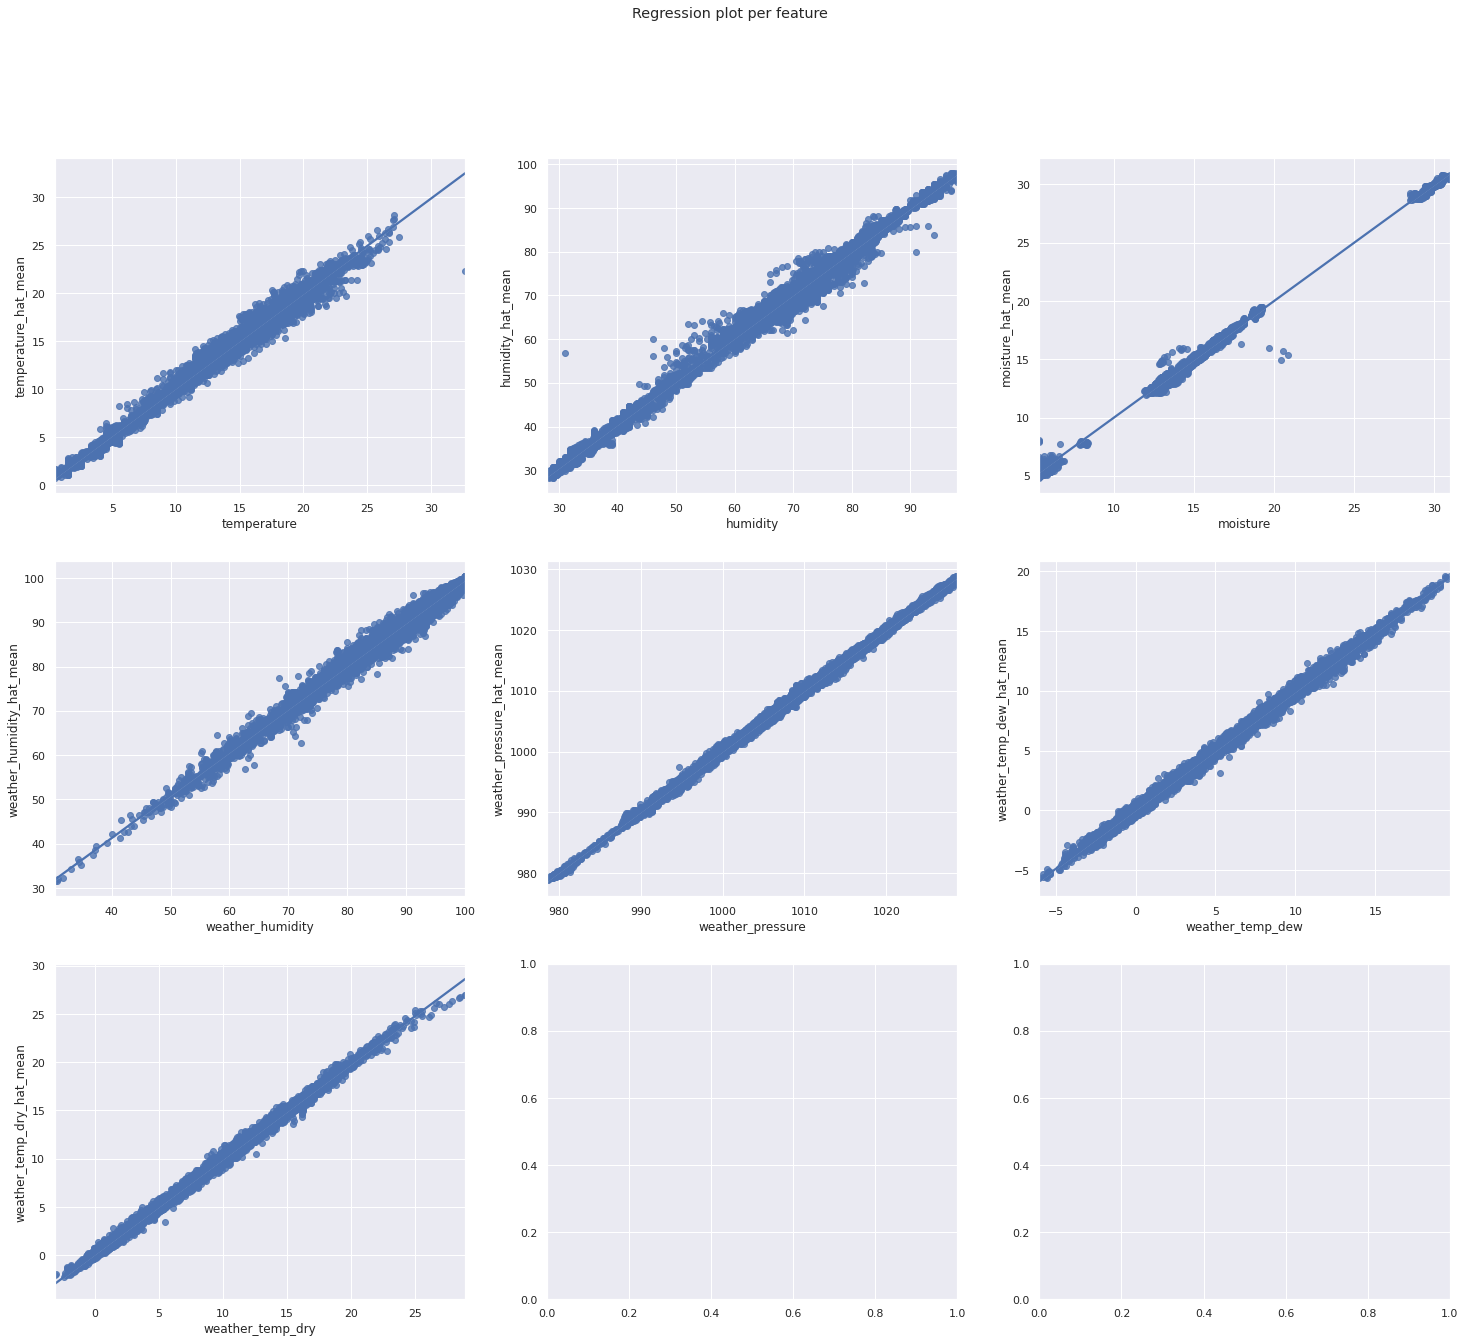

In [38]:
num_features = preprocess.num_features - 4
num_cols = 3
num_rows = int(np.ceil(num_features/num_cols))
sns.set_theme(color_codes=True)
fig, axes = plt.subplots(num_rows,num_cols, figsize=(25,7*num_rows))
fig.suptitle('Regression plot per feature')

for i,f in enumerate(preprocess.features[:t_idx]):
  sns.regplot(ax=axes.flatten()[i],x=f,y=f+'_hat_mean',data=rnn_df_val_stat)

### Test samples

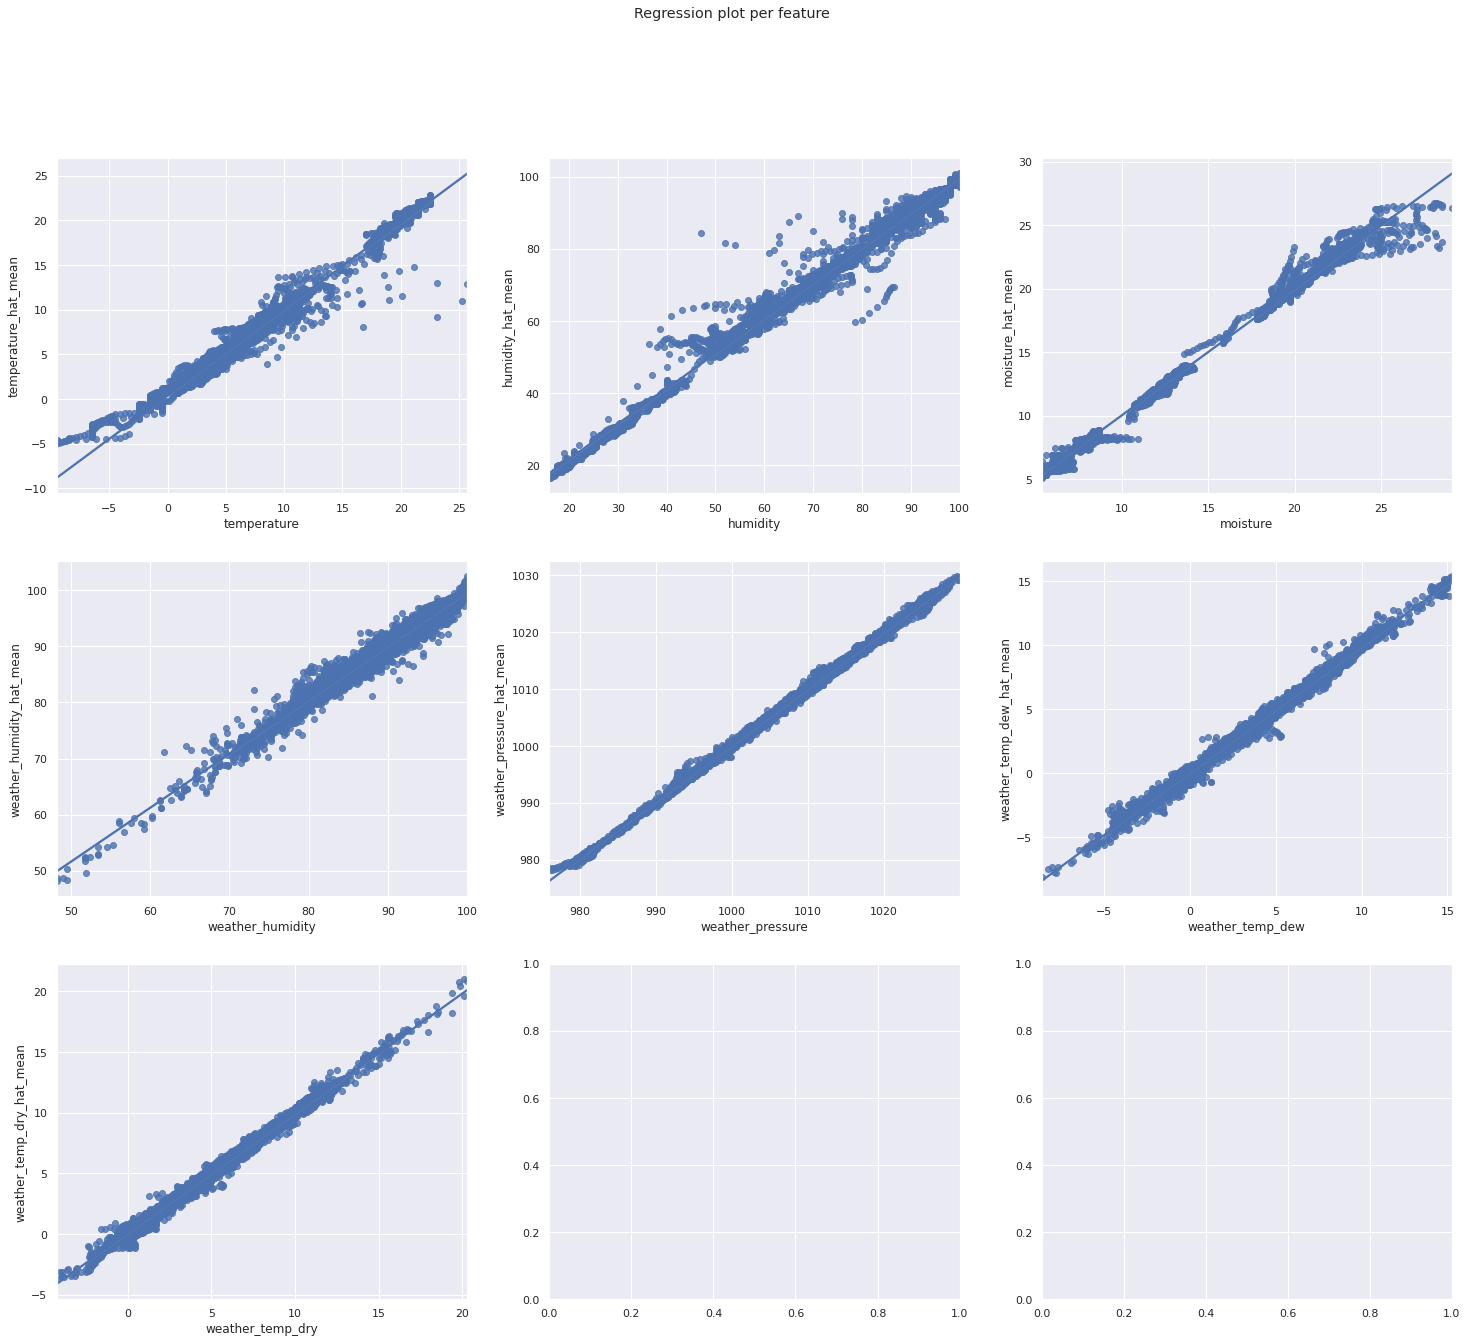

In [39]:
num_features = preprocess.num_features - 4
num_cols = 3
num_rows = int(np.ceil(num_features/num_cols))
sns.set_theme(color_codes=True)
fig, axes = plt.subplots(num_rows,num_cols, figsize=(25,7*num_rows))
fig.suptitle('Regression plot per feature')

for i,f in enumerate(preprocess.features[:t_idx]):
  sns.regplot(ax=axes.flatten()[i],x=f,y=f+'_hat_mean',data=rnn_df_test_stat)

## Plotting line plot with original and reconstructed signal

### Validation samples

In [40]:
import plotly.graph_objects as go
print('Segments in validation to choose from:')
rnn_df_val_stat.groupby(['sensor_id','segment_id']).size()

Segments in validation to choose from:


sensor_id  segment_id
3.0        4.0             27
           5.0            864
           6.0             54
           7.0            225
           8.0             89
           9.0             70
           10.0            66
           11.0           527
           12.0           414
           13.0           178
8.0        27.0           101
           28.0            58
           29.0            99
           30.0            90
           31.0            88
           32.0           329
10.0       35.0            38
           36.0          1524
17.0       58.0           157
           59.0           518
19.0       66.0           206
26.0       80.0           459
           81.0            37
27.0       82.0            51
           83.0           385
           84.0           300
           85.0            41
           86.0            46
           87.0            46
34.0       98.0           757
           99.0            94
           100.0           75
           101.0  

In [41]:
segment = 36
f = 'temperature'
# Create traces
fig = go.Figure()

df = rnn_df_val_stat

fig.add_trace(go.Scatter(x = df.loc[df.segment_id==segment,'timestamp'],
                  y=df.loc[df.segment_id==segment,f],
                  mode='lines',
                  name=f))

fig.add_trace(go.Scatter(x = df.loc[df.segment_id == segment,'timestamp'],
                  y=df.loc[df.segment_id==segment,f+'_hat_mean'],
                  mode='lines',
                  name=f+' mean reconstruction'))

fig.add_trace(go.Scatter(
  name='Upper Bound',
  x=df.loc[df.segment_id==segment,'timestamp'],
  y=df.loc[df.segment_id==segment,f+'_hat_mean'] + df.loc[df.segment_id==segment,f+'_hat_std'] ,
  mode='lines',
  marker=dict(color="#444"),
  line=dict(width=0),
  showlegend=False
))

fig.add_trace(go.Scatter(
    name='Std. Dev. margin',
    x=df.loc[df.segment_id==segment,'timestamp'],
    y=df.loc[df.segment_id==segment,f+'_hat_mean'] - df.loc[df.segment_id==segment,f+'_hat_std'],
    marker=dict(color="#444"),
    line=dict(width=0),
    mode='lines',
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty',
    showlegend=True
))

#style layout 
layout = go.Layout(
    xaxis=dict(
        title="Time"
    ),
    yaxis=dict(
        title=f"{f}"
    ),
    title='Original vs reconstructed signal with 1 standard deviation as lower and upper bound' ) 
fig.layout = layout


fig.show()

### Test sample with outlier flagging

In [42]:
print('Segments in test to choose from:')
rnn_df_test_stat.groupby(['sensor_id','segment_id']).size()

Segments in test to choose from:


sensor_id  segment_id
16.0       53.0           162
           54.0           173
           55.0          1289
           56.0            74
           57.0            65
50.0       150.0          238
           151.0           74
           153.0          246
           154.0          776
           155.0          751
54.0       160.0         1697
           162.0           63
           163.0           74
60.0       179.0          210
           180.0         1336
           181.0           79
dtype: int64

In [43]:
sensor = 54
segment = 160
f = 'moisture'
# Create traces
fig = go.Figure()

df = rnn_df_test_stat

fig.add_trace(go.Scatter(x = df.loc[df.segment_id==segment,'timestamp'],
                  y=df.loc[df.segment_id==segment,f],
                  mode='lines',
                  name=f))

fig.add_trace(go.Scatter(x = df.loc[(df.segment_id==segment) & df.Outlier == True,'timestamp'],
                  y=df.loc[(df.segment_id==segment) & (df.Outlier == True),f],
                  mode='markers',
                  name='MSE outlier'))

fig.add_trace(go.Scatter(x = df.loc[df.segment_id == segment,'timestamp'],
                  y=df.loc[df.segment_id==segment,f+'_hat_mean'],
                  mode='lines',
                  name=f+' mean reconstruction'))

fig.add_trace(go.Scatter(
  name='Upper Bound',
  x=df.loc[df.segment_id==segment,'timestamp'],
  y=df.loc[df.segment_id==segment,f+'_hat_mean'] + df.loc[df.segment_id==segment,f+'_hat_std'] ,
  mode='lines',
  marker=dict(color="#444"),
  line=dict(width=0),
  showlegend=False
))

fig.add_trace(go.Scatter(
    name='Std. Dev. margin',
    x=df.loc[df.segment_id==segment,'timestamp'],
    y=df.loc[df.segment_id==segment,f+'_hat_mean'] - df.loc[df.segment_id==segment,f+'_hat_std'],
    marker=dict(color="#444"),
    line=dict(width=0),
    mode='lines',
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty',
    showlegend=True
))

#style layout 
layout = go.Layout(
    xaxis=dict(
        title="Time"
    ),
    yaxis=dict(
        title=f"Moisture (% water in wood)"
    ),
    title=f'Original vs mean reconstructed signal with 1 standard deviation as lower and upper bound for sensor {sensor} in segment {segment}' ) 
fig.layout = layout


fig.show()

# Generate samples from prior

## Exploring conditional features importance

In [44]:
t_df = pd.DataFrame()

t_df['time'] = pd.date_range(start='07/01/2020',end='12/30/2020',freq='H')[:-1]
t_df['doy'] = t_df['time'].dt.dayofyear
t_df['tod'] = t_df['time'].dt.hour
t_df['dom'] = t_df['time'].dt.day

t_df = t_df[t_df.dom == 1].drop(columns=['dom'])

doy_sin = np.sin(t_df['doy']/365*2*np.pi).to_numpy()
doy_cos = np.cos(t_df['doy']/365*2*np.pi).to_numpy()

tod_sin = np.sin(t_df['tod']/24*2*np.pi).to_numpy()
tod_cos = np.cos(t_df['tod']/24*2*np.pi).to_numpy()

c = np.vstack((tod_sin,tod_cos,doy_sin,doy_cos)).T
c = np.reshape(c,(-1,24,4))
cc = c.copy()

c = torch.from_numpy(c).float().to(device)

with torch.no_grad():

  pz = rnnvae.prior(batch_size=1)

  z = pz.sample().repeat(c.size(0),1,1)
  #z = z[:,-1,:,:]

  x_hat = rnnvae.decoder(z,c)

  x_hat = x_hat.reshape(-1,7).cpu().numpy()
  x_hat = preprocess.standardiser.inverse_transform(x_hat)

#### Plot months in order along timeline

In [45]:
import plotly.graph_objects as go


feature = 'weather_temp_dry'

x_hat_plotly = x_hat[:,feature_dict[feature]]

# Create traces
fig = go.Figure()


fig.add_trace(go.Scatter(y=x_hat_plotly,
                  mode='lines',
                  name=f'Generated outside temperature',
                  showlegend=False
                  ))
    

for i in range(6):

  fig.add_shape(type="line",
    x0=24*i, y0=x_hat_plotly.min()-5, x1=24*i, y1=x_hat_plotly.max()+5,
    line=dict(
        color="grey",
        width=1,
        dash="dashdot",
    ))
  
fig.update_layout(
    xaxis = dict(
        title='Date',
        tickmode = 'array',
        tickvals = [12+i*24 for i in range(6)],
        ticktext = ['1. Jul.','1. Aug.','1. Sep','1. Okt.','1. Nov.','1. Dec.']
    ),
    title = 'Generated data while varying on day of year conditions while z sample and time of day conditions are fixed'
)

fig.update_layout(
    yaxis = dict(
        title='Celsius'
    )
)


fig.show()

#### Plot months after color

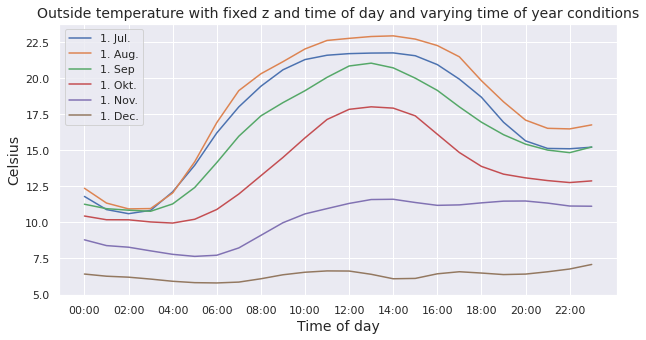

In [46]:
feature = 'weather_temp_dry'

x_hat_plot = x_hat[:,feature_dict[feature]]

x_hat_plot = x_hat_plot.reshape(-1,24,1)

plt.figure(figsize=(10,5))

for i,m in enumerate(['1. Jul.','1. Aug.','1. Sep','1. Okt.','1. Nov.','1. Dec.']):

  plt.plot(x_hat_plot[i],label=m)

plt.legend()
plt.xticks(ticks=range(0,24,2),labels=['00:00','02:00','04:00','06:00','08:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00'])
plt.title('Outside temperature with fixed z and time of day and varying time of year conditions',size='14')
plt.ylabel('Celsius',fontsize=14)
plt.xlabel('Time of day',fontsize=14)

plt.show()


## Plotting tod sin and tod cos for 0:24 and 12:24

In [47]:
t_df = pd.DataFrame()

t_df['time'] = pd.date_range(start='07/01/2020',end='07/03/2020',freq='H')[:-1]
t_df['doy'] = t_df['time'].dt.dayofyear
t_df['tod'] = t_df['time'].dt.hour

doy_sin_1 = np.sin(t_df.loc[:23,'doy']/365*2*np.pi).to_numpy()
doy_cos_1 = np.cos(t_df.loc[:23,'doy']/365*2*np.pi).to_numpy()

doy_sin_2 = np.sin(t_df.loc[12:35,'doy']/365*2*np.pi).to_numpy()
doy_cos_2 = np.cos(t_df.loc[12:35,'doy']/365*2*np.pi).to_numpy()

tod_sin_1 = np.sin(t_df.loc[:23,'tod']/24*2*np.pi).to_numpy()
tod_cos_1 = np.cos(t_df.loc[:23,'tod']/24*2*np.pi).to_numpy()

tod_sin_2 = np.sin(t_df.loc[12:35,'tod']/24*2*np.pi).to_numpy()
tod_cos_2 = np.cos(t_df.loc[12:35,'tod']/24*2*np.pi).to_numpy()

doy_sin = np.hstack([doy_sin_1,doy_sin_2])
doy_cos = np.hstack([doy_cos_1,doy_cos_2])

tod_sin = np.hstack([tod_sin_1,tod_sin_2])
tod_cos = np.hstack([tod_cos_1,tod_cos_2])

c = np.vstack((tod_sin,tod_cos,doy_sin,doy_cos)).T
c = np.reshape(c,(-1,24,4))
cc = c.copy()

c = torch.from_numpy(c).float().to(device)

with torch.no_grad():

  pz = rnnvae.prior(batch_size=1)

  z = pz.sample().repeat(c.size(0),1,1)

  x_hat = rnnvae.decoder(z,c)

  x_hat = x_hat.cpu().numpy()

In [48]:
x_hat = preprocess.standardiser.inverse_transform(x_hat)

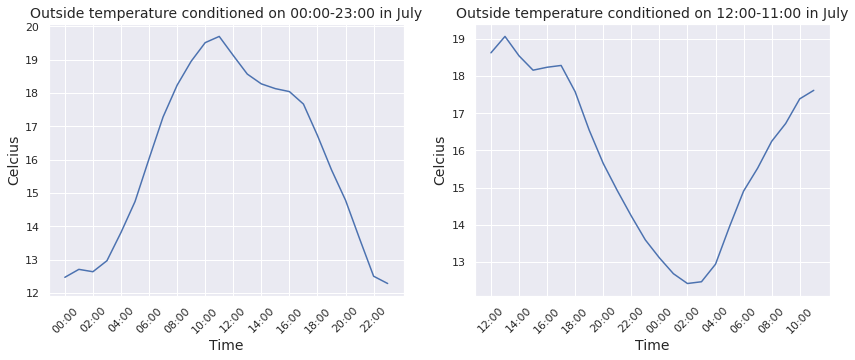

In [49]:
x_hat

fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].plot(x_hat[0,:,6])
axes[0].set_xticks(range(0,24,2))
axes[0].set_xticklabels(['00:00','02:00','04:00','06:00','08:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00'],
                        rotation=45)
axes[0].set_xlabel('Time',fontsize=14)
axes[0].set_ylabel('Celcius',fontsize=14)
axes[0].set_title('Outside temperature conditioned on 00:00-23:00 in July',size='14')


axes[1].plot(x_hat[1,:,6])
axes[1].set_xticks(range(0,24,2))
axes[1].set_xticklabels(['12:00','14:00','16:00','18:00','20:00','22:00','00:00','02:00','04:00','06:00','08:00','10:00'],
                        rotation=45)
axes[1].set_xlabel('Time',fontsize=14)
axes[1].set_ylabel('Celcius',fontsize=14)
axes[1].set_title('Outside temperature conditioned on 12:00-11:00 in July',size='14')


plt.show()

## Generating samples over time from July to Dec. 

In [50]:
with torch.no_grad():

  t_df = pd.DataFrame()

  t_df['time'] = pd.date_range(start='07/01/2020',end='12/30/2020',freq='H')[:-1]
  t_df['doy'] = t_df['time'].dt.dayofyear
  t_df['tod'] = t_df['time'].dt.hour

  doy_sin = np.sin(t_df['doy']/365*2*np.pi).to_numpy()
  doy_cos = np.cos(t_df['doy']/365*2*np.pi).to_numpy()

  tod_sin = np.sin(t_df['doy']/24*2*np.pi).to_numpy()
  tod_cos = np.cos(t_df['doy']/24*2*np.pi).to_numpy()

  c = np.vstack((tod_sin,tod_cos,doy_sin,doy_cos)).T
  c = np.reshape(c,(-1,24,4))

  c = torch.from_numpy(c).float().to(device)
          
  # degine the prior p(z)
  pz = rnnvae.prior(batch_size=c.size(0))

  # sample the prior 
  z = pz.sample()

  # define the observation model 
  x_hat = rnnvae.observation_model(z,c).cpu().view(-1,7).numpy()

In [51]:
# Plotting results
fig = go.Figure()

chosen_feature = 'weather_temp_dry'

f_idx = feature_dict[chosen_feature]

x_hat_plotly = preprocess.standardiser.inverse_transform(x_hat)


fig.add_trace(go.Scatter(x=t_df['time'],
                          y=x_hat_plotly[:,f_idx],
                  mode='lines',
                  name=f))
  

#style layout 
layout = go.Layout(
    xaxis=dict(
        title="Time"
    ),
    yaxis=dict(
        title=f"Celsius"
    ),
    title = 'Outside temperature generated from July to December') 
fig.layout = layout


fig.show()

# Exploring latent space 
In this scenario the values for the conditional features becomes fixed while some of the latent space features will vary between -2 and 2

In [53]:
z = torch.zeros(latent_features,9,latent_features)
z_range = torch.arange(start=-2,end=2.5,step=0.5)

for i in range(z.size(0)):
  #for j in range(z.size(2)):
  z[i,:,i] = z_range 

z = z.view(-1,1,latent_features)


doy = np.repeat(182,ws)[:,np.newaxis]
doy_sin = np.sin(doy/365*2*np.pi)
doy_cos = np.cos(doy/365*2*np.pi)

tod = np.tile(np.arange(0,24),doy.max()-doy.min()+1)[:,np.newaxis]
tod_sin = np.sin(tod/24*2*np.pi)
tod_cos = np.cos(tod/24*2*np.pi)

c = np.hstack((doy_sin,doy_cos,tod_sin,tod_cos))
c = np.reshape(c,(-1,24,4))
c = torch.from_numpy(c).float().repeat(z.size(0),1,1).to(device)

with torch.no_grad():

  z = z.to(device)

  x_hat = rnnvae.decoder(z,c)

  x_hat = x_hat.reshape(-1,7).cpu().numpy()

  x_hat = preprocess.standardiser.inverse_transform(x_hat)

  x_hat = x_hat.reshape(latent_features,9,-1,7)

#Prepare as x-axis for plotting
z_range = z_range.numpy().repeat(ws)

In [56]:
# Create traces
fig = go.Figure()

chosen_feature = 'moisture'

f_idx = feature_dict[chosen_feature]

x_plot = x_hat[:,:,:,f_idx].reshape(latent_features,-1)

z_range = z_range.repeat(ws)

for i in range(x_plot.shape[0]):

  fig.add_trace(go.Scatter(y=x_plot[i,:],
                    mode='lines',
                    name=f'Dim {i+1}'))


fig.update_layout(
    xaxis = dict(
        title='Latent space value',
        tickmode = 'array',
        tickvals = [12+i*24 for i in range(24)],
        ticktext = [-2,-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0]
    ),
    title = f'Latent Space range values for {chosen_feature}'
)

for i in range(9):

  fig.add_shape(type="line",
    x0=24*i, y0=x_plot.min()-5, x1=24*i, y1=x_plot.max()+5,
    line=dict(
        color="grey",
        width=1,
        dash="dashdot",
    ))


fig.show()

# Color coded embeddings of latent space

## Embedding colored after sensor

Text(0.5, 1.0, 't-SNE of latent space for test set colored after sensors in test set')

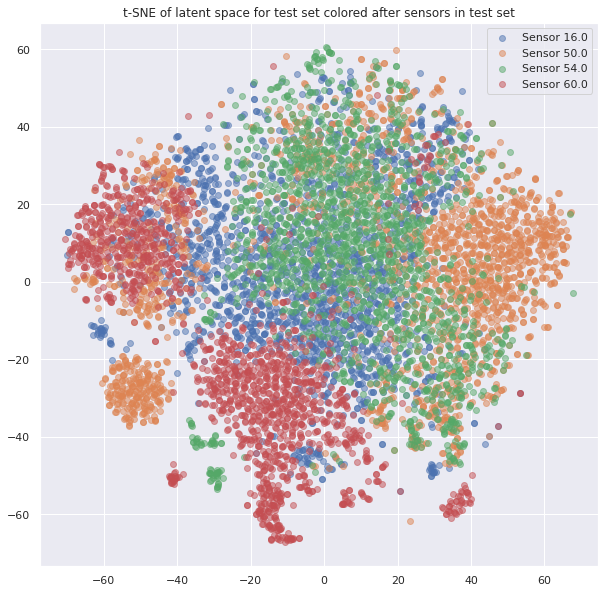

In [57]:
fig, axes = plt.subplots(1,1, figsize=(10,10))

#picked_sensors = [ 3., 13.,20.,27., 28., 35., 39., 43., 73.]
#picked_sensors = [3,28,39,43]

z_all = np.array(rnn_df_test['latent_space'].tolist())
sensors = rnn_df_test['sensor_id'].to_numpy()

s = np.unique(np.hstack([z_all,sensors[:,np.newaxis]]),axis=0)

z_all = s[:,:32]
sensors = s[:,32]

unique_sensors = np.unique(sensors)

palette = sns.color_palette()


z = TSNE(n_components=2).fit_transform(z_all)

for i, sensor in enumerate(unique_sensors):
  sensor_mask = sensors == sensor
  z_tmp = z[sensor_mask]
  sc = axes.scatter(z_tmp[:,0],z_tmp[:,1],color=palette[i],label='Sensor '+str(sensor),alpha=0.5)

axes.legend()

axes.set_title('t-SNE of latent space for test set colored after sensors in test set')



## Plotting outlier embeddings

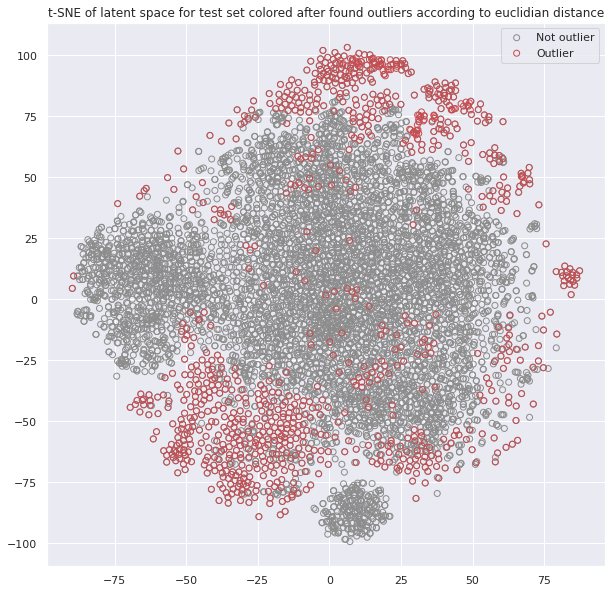

In [58]:
fig, axes = plt.subplots(1,1, figsize=(10,10))

rnn_df_test_outlier = rnn_df_test.merge(rnn_df_test_stat[['timestamp','sensor_id','segment_id','Outlier']], how='left',on=['sensor_id','segment_id','timestamp']).dropna()

z_all = np.array(rnn_df_test_outlier['latent_space'].tolist())
outlier = (rnn_df_test_outlier['Outlier']*1).to_numpy().astype(int)

s = np.unique(np.hstack([z_all,outlier[:,np.newaxis]]),axis=0)

z_all = s[:,:32]
outlier = s[:,32]

palette = sns.color_palette()

not_outlier_color = palette[7]
outlier_color = palette[3]

z = TSNE(n_components=2).fit_transform(z_all)

for c,name,i in zip([not_outlier_color,outlier_color],['Not outlier','Outlier'],[0,1]):
  outlier_mask = outlier == i
  z_tmp = z[outlier_mask]

  #axes.scatter(z_tmp[:,0],z_tmp[:,1],color=c,label=name,alpha=1)
  axes.scatter(z_tmp[:,0],z_tmp[:,1],facecolors='none',edgecolors=c,label=name,alpha=1)

axes.legend()

axes.set_title('t-SNE of latent space for test set colored after found outliers according to euclidian distance')



plt.show()




## Latent space colored after time in year on test set

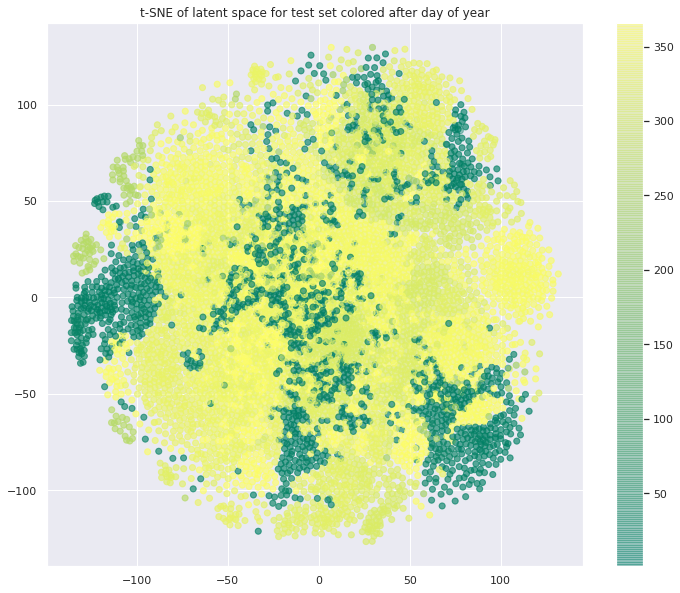

In [59]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,1, figsize=(12,10))

rnn_df_test['doy'] = rnn_df_test.timestamp.dt.dayofyear

z_all = np.array(rnn_df_test['latent_space'].tolist())
sensors = rnn_df_test['doy'].to_numpy()

s = np.unique(np.hstack([z_all,sensors[:,np.newaxis]]),axis=0)

z_all = s[:,:32]
doy = s[:,32]

cm = plt.cm.get_cmap('summer')

z = TSNE(n_components=2).fit_transform(z_all)

sc = axes.scatter(z[:,0],z[:,1],c=doy,vmin=doy.min(),vmax=doy.max(),cmap=cm,alpha=0.4,facecolors='none')

axes.set_title('t-SNE of latent space for test set colored after day of year')

fig.colorbar(sc,ax=axes)
